# Eco-efficiency as a decision support tool to compare renewable energy systems

This file contains the code used to compile the results for the article 'Eco-efficiency as a decision support tool to compare renewable energy systems'. Python version 3.9.16 and the python package brightway2 version 2.4.3 is used. Additionally, a VUB internally developed design and optimization framework is used for simulating the various energy sysems and their production. Further explanation about the methodology are provided in the article published an Energies special issue on 'Life Cycle Assessment in Renewable and Sustainable Energies' (https://www.mdpi.com/journal/energies/special_issues/ZN7187TO06). This research was funded by Vlaams Agentschap Innoveren & Ondernemen (VLAIO) in
the framework of the MAMuET and OPTIMESH project.\\

# 1.Set-up

First, the required python packages are imported, the project is set up and the ecoinvent database version 3.8. cut-off is imported.

In [1]:
import brightway2 as bw
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl

In [2]:
import datetime
from simugrid.management import RationalManager, DieterenManager, DietereBestManager, MPCManager, SimpleManager
from simugrid.misc.log_plot_micro import log_micro, setup_logs
from simugrid.misc.scenarios import mordor_microgrid
from simugrid.utils import DATA_DIR
from simugrid.simulation.config_parser import parse_config_file
from simugrid.rewards.reward import DefaultReward
from simugrid.misc.log_plot_micro import plot_files
from simugrid.assets import *
from scipy import stats

In [3]:
bw.projects.set_current('MAMUeT2.0')
bw.projects.current

'MAMUeT2.0'

In [4]:
bw.bw2setup()

Biosphere database already present!!! No setup is needed


In [5]:
my_bio = bw.Database('biosphere3')

In [6]:
fpei38 = r'C:\Users\dhuber\OneDrive - Vrije Universiteit Brussel\11_Data\02_Ecoinvent_3.8\datasets'

In [7]:
if 'ecoinvent 3.8 cutoff' in bw.databases:
    print("Database has already been imported")
else:
    ei38 = bw.SingleOutputEcospold2Importer(fpei38, 'ecoinvent 3.8 cutoff')
    ei38.apply_strategies()
    ei38.statistics()

Database has already been imported


In [8]:
#ei38.write_database()

In [9]:
eidb = bw.Database('ecoinvent 3.8 cutoff')
pvlci=bw.Database('PV_LCI')
batlci=bw.Database('Battery_LCI')
bw.databases

Databases dictionary with 4 object(s):
	Battery_LCI
	PV_LCI
	biosphere3
	ecoinvent 3.8 cutoff

In [10]:
print(type(eidb))

<class 'bw2data.backends.peewee.database.SQLiteBackend'>


In [11]:
ipcc=[method for method in bw.methods if 'no LT' not in str(method) 
                                and 'Endpoint' not in str(method)
                                and 'superseded' not in str(method)
                                and 'climate change' in str(method)
                                and 'GWP 100a' in str(method)
                                and 'IPCC 2013' in str(method)][0]
print(ipcc)
print(type(ipcc))

('IPCC 2013', 'climate change', 'GWP 100a')
<class 'tuple'>


In [12]:
method_ipcc = bw.Method(ipcc)
print(type(method_ipcc))

<class 'bw2data.method.Method'>


# 2. Set-up of the energy system and consumption validation

The following section defines the input for the design- and optimization framework. Afterwards, the defined asset sizes are derived and the amount of generated, stored and consumed electrcity is called from the framework. As a last step, the selected week are compared to the minimum and maximum consumption in the respective season.

In [13]:
config_file = "C:/Users/dhuber/OneDrive - Vrije Universiteit Brussel/10_Design_optimization_framework/MAMUeT/GEP_case/scenario_4+EV.csv"
mordor = parse_config_file(config_file)

to use the PublicGrid PublicGrid_0 asset the environment should contain keys of one of the following conditions: PowerProfile case: PublicGrid_0; PublicGrid case: sell_to_grid_0, buy_from_grid_0
to use the SolarPv SolarPv_0 asset the environment should contain keys of one of the following conditions: PowerProfile case: SolarPv_0; SolarPv case: irradiation
to use the WindTurbine WindTurbine_0 asset the environment should contain keys of one of the following conditions: PowerProfile case: WindTurbine_0; WindTurbine case: wind_speed


In [14]:
reward = DefaultReward()
mordor.set_reward(reward)

In [15]:
ems = RationalManager(mordor)

In [16]:
log_dir_name = "C:/Users/dhuber/OneDrive - Vrije Universiteit Brussel/10_Design_optimization_framework/Case_studies/Results/Results/"
tot_steps = 24 * 365
log_dir = setup_logs(mordor, log_dir_name, "mordor_microgrid", tot_steps, config_file=config_file)
mordor.attribute_to_log("Battery_0", "soc")
# mordor.attribute_to_log("PublicGrid_0", "power_output")
mordor.attribute_to_log("Battery_0", "power_output")


In [17]:
for i in range(tot_steps):
    mordor.management_system.simulate_step()

In [18]:
pv_cap = mordor.assets[2].max_production_power
pv_cap

765

In [19]:
lfp_cap = mordor.assets[54].size
lfp_cap

342.5

In [20]:
nmc_cap = mordor.assets[55].size
nmc_cap

342.5

In [21]:
wind_cap = (mordor.assets[3].max_production_power)/1000 #the max_production_power is in kW and the ecoinvent dataset is in MW.
wind_cap

0.69

In [22]:
cons_hist = mordor.power_hist[0]["Consumer_0"]

electric_consumer = list()

for power in cons_hist:
    electric_consumer.append(power.electrical)
print("Total consumption household: ",sum(electric_consumer))

Total consumption household:  -3407238.0000047283


Weekday   Hour    
Saturday  00:00:00    206.015008
          01:00:00    264.438390
          02:00:00    263.173183
          03:00:00    274.292078
          04:00:00    266.924707
                         ...    
Friday    19:00:00    309.612716
          20:00:00    289.851068
          21:00:00    283.867624
          22:00:00    271.798976
          23:00:00     82.536933
Name: Consumption, Length: 168, dtype: float64


[Text(24, 0, '24'),
 Text(48, 0, '48'),
 Text(72, 0, '72'),
 Text(96, 0, '96'),
 Text(120, 0, '120'),
 Text(144, 0, '144'),
 Text(168, 0, '168')]

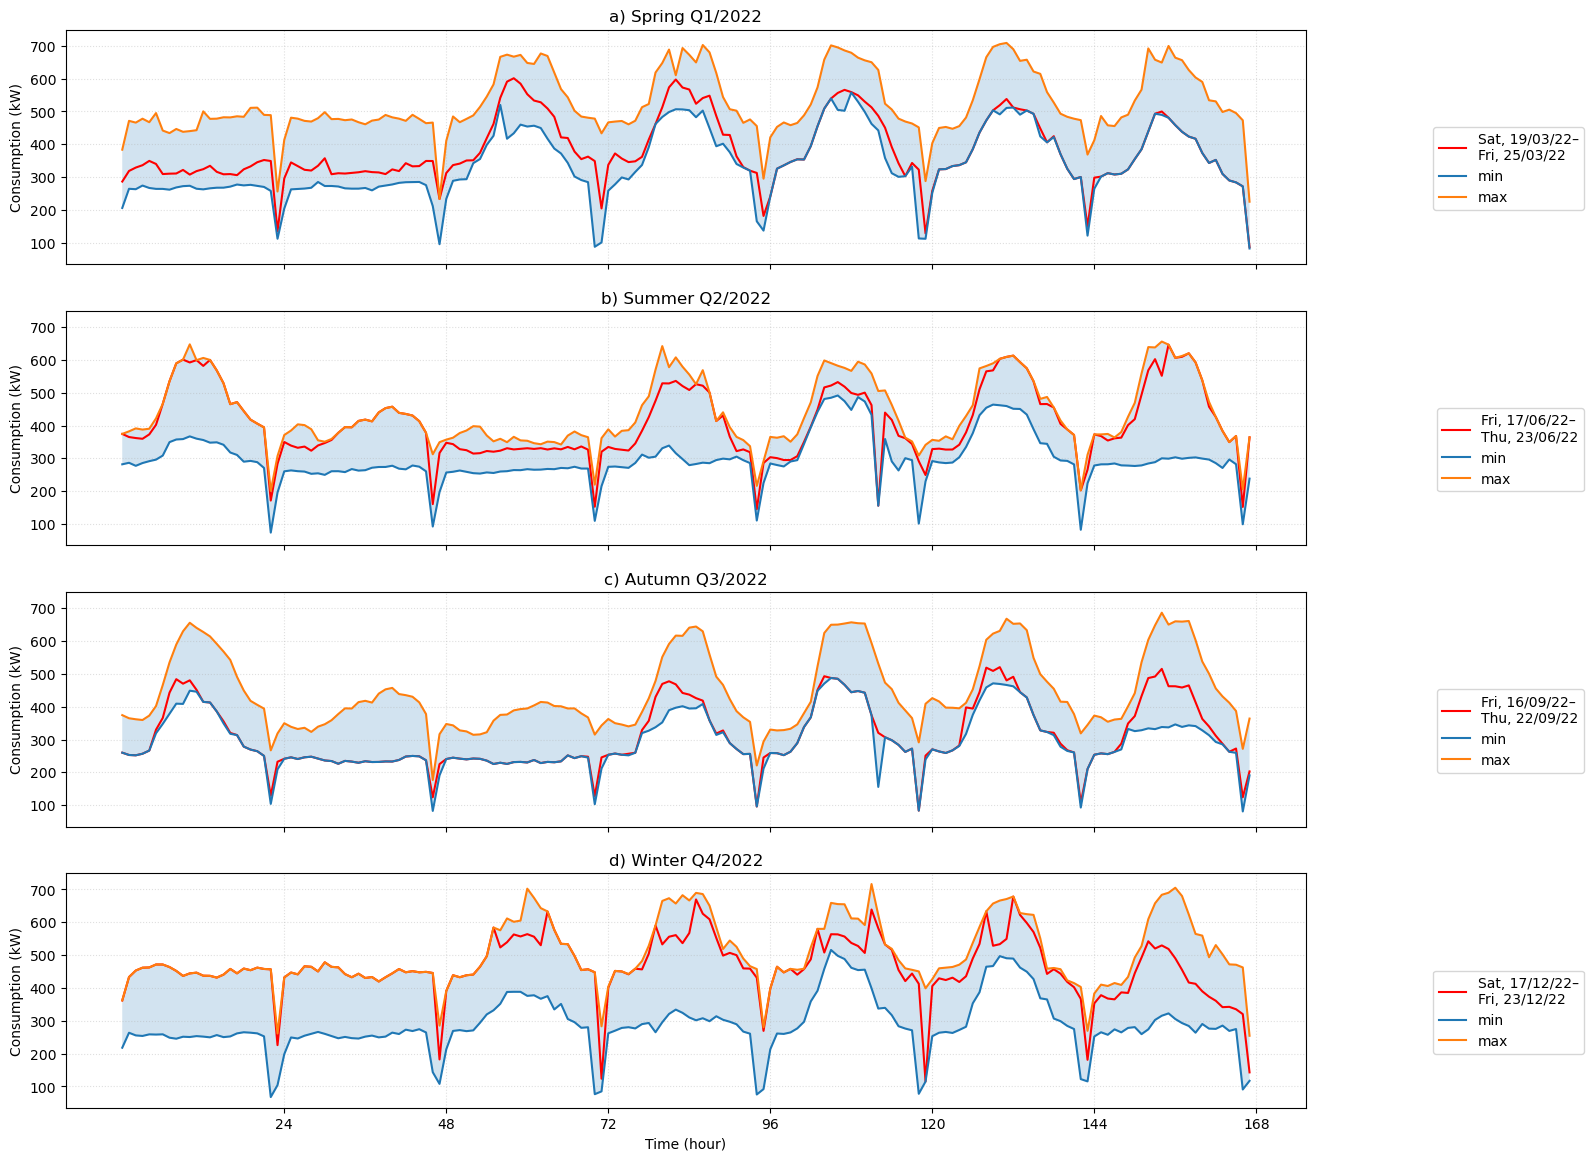

In [23]:
from statistics import mean

year= 2022
timestep = pd.Series(pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31 23:00:00', freq='H'))
dates = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31')
num_repeats = 24

a= pd.DataFrame({'Timestamp': timestep})
a['Date']= pd.DataFrame(dates.repeat(num_repeats),columns=['date'])
a['Hour'] = pd.to_datetime(a['Timestamp']).dt.strftime('%H:%M:%S')
a['Weekday']=a['Date'].dt.day_name()
a['Quarter']=a['Date'].dt.quarter
a['Consumption']=electric_consumer

q1= a[a['Quarter'] ==1]
q2= a[a['Quarter'] ==2]
q3= a[a['Quarter'] ==3]
q4= a[a['Quarter'] ==4]

#mean_q11 = a.groupby(['Weekday', 'Hour']).apply(lambda x: x[x['Quarter'] == '1']['Consumption'].mean())
min_q1 = q1.groupby(['Weekday', 'Hour'], sort=False)['Consumption'].max()*-1
max_q1 = q1.groupby(['Weekday', 'Hour'], sort=False)['Consumption'].min()*-1
mean_q1 = q1.groupby(['Weekday', 'Hour'], sort=False)['Consumption'].mean()*-1
min_q2 = q2.groupby(['Weekday', 'Hour'], sort=False)['Consumption'].max()*-1
max_q2 = q2.groupby(['Weekday', 'Hour'], sort=False)['Consumption'].min()*-1
mean_q2 = q2.groupby(['Weekday', 'Hour'], sort=False)['Consumption'].mean()*-1
min_q3 = q3.groupby(['Weekday', 'Hour'], sort=False)['Consumption'].max()*-1
max_q3 = q3.groupby(['Weekday', 'Hour'], sort=False)['Consumption'].min()*-1
mean_q3 = q3.groupby(['Weekday', 'Hour'], sort=False)['Consumption'].mean()*-1
min_q4 = q4.groupby(['Weekday', 'Hour'], sort=False)['Consumption'].max()*-1
max_q4 = q4.groupby(['Weekday', 'Hour'], sort=False)['Consumption'].min()*-1
mean_q4 = q4.groupby(['Weekday', 'Hour'], sort=False)['Consumption'].mean()*-1
print(min_q1)

x_values = range(168)
fig, axs = plt.subplots(4, 1, figsize=(16, 14), sharey='col', sharex='col')
axs[0].fill_between(x_values, max_q1, min_q1, alpha=0.2)
axs[0].plot([i*-1 for i in electric_consumer[1848:2016]], label='Sat, 19/03/22–\nFri, 25/03/22', color='r')
axs[0].plot(min_q1.tolist(), label='min')
axs[0].plot(max_q1.tolist(), label='max')
axs[0].set_ylabel('Consumption (kW)')
axs[0].legend()
axs[0].legend(bbox_to_anchor=(1.23, 0.2), loc='lower right', ncol= 1)
axs[0].set_title('a) Spring Q1/2022')
axs[0].grid(linestyle='dotted',alpha=0.4)
axs[0].set_xticks([24, 48, 72, 96, 120, 144, 168]) 
axs[0].set_xticklabels([24, 48, 72, 96, 120, 144, 168]) #, fontsize=12

axs[1].fill_between(x_values, max_q2, min_q2, alpha=0.2)
axs[1].plot([i*-1 for i in electric_consumer[4008:4176]], label='Fri, 17/06/22–\nThu, 23/06/22', color='r')
axs[1].plot(min_q2.tolist(), label='min')
axs[1].plot(max_q2.tolist(), label='max')
axs[1].set_ylabel('Consumption (kW)')
axs[1].legend()
axs[1].legend(bbox_to_anchor=(1.23, 0.2), loc='lower right', ncol= 1)
axs[1].set_title('b) Summer Q2/2022')
axs[1].grid(linestyle='dotted',alpha=0.4)
axs[1].set_xticks([24, 48, 72, 96, 120, 144, 168]) 
axs[1].set_xticklabels([24, 48, 72, 96, 120, 144, 168])#, fontsize=12

axs[2].fill_between(x_values, max_q3, min_q3, alpha=0.2)
axs[2].plot([i*-1 for i in electric_consumer[6192:6360]], label='Fri, 16/09/22–\nThu, 22/09/22', color='r')
axs[2].plot(min_q3.tolist(), label='min')
axs[2].plot(max_q3.tolist(), label='max')
axs[2].set_ylabel('Consumption (kW)')
axs[2].legend()
axs[2].legend(bbox_to_anchor=(1.23, 0.2), loc='lower right', ncol= 1)
axs[2].set_title('c) Autumn Q3/2022')
axs[2].grid(linestyle='dotted',alpha=0.4)
axs[2].set_xticks([24, 48, 72, 96, 120, 144, 168]) 
axs[2].set_xticklabels([24, 48, 72, 96, 120, 144, 168]) #, fontsize=12

axs[3].fill_between(x_values, max_q4, min_q4, alpha=0.2)
axs[3].plot([i*-1 for i in electric_consumer[8400:8568]], label='Sat, 17/12/22–\nFri, 23/12/22', color='r')
axs[3].plot(min_q4.tolist(), label='min')
axs[3].plot(max_q4.tolist(), label='max')
axs[3].set_ylabel('Consumption (kW)')
axs[3].set_xlabel('Time (hour)')
axs[3].legend()
axs[3].legend(bbox_to_anchor=(1.23, 0.2), loc='lower right', ncol= 1)
axs[3].set_title('d) Winter Q4/2022')
axs[3].grid(linestyle='dotted',alpha=0.4)
axs[3].set_xticks([24, 48, 72, 96, 120, 144, 168]) 
axs[3].set_xticklabels([24, 48, 72, 96, 120, 144, 168])#, fontsize=12

#plt.rcParams.update({'font.size': 16})

#a.to_excel(r'C:\Users\dhuber\OneDrive - Vrije Universiteit Brussel\10_Design_optimization_framework\MAMUeT\GEP_case\Test.xlsx')

In [24]:
solar_pv_hist = mordor.power_hist[0]["SolarPv_0"]

electric_solar = list()

for power in solar_pv_hist:
    electric_solar.append(power.electrical)
print("Total production solar: ",sum(electric_solar))

print(max(electric_solar))

Total production solar:  940290.2149925784
765.0


In [25]:
wind_hist = mordor.power_hist[0]["WindTurbine_0"]

electric_wind = list()

for power in wind_hist:
    electric_wind.append(power.electrical)
print("Total production wind turbine: ",sum(electric_wind))

Total production wind turbine:  1859228.592992668


In [26]:
grid_hist = mordor.power_hist[0]["PublicGrid_0"]

electric_grid_tot = list()

for power in grid_hist:
    electric_grid_tot.append(power.electrical)
print("Total consumption grid: ", sum(electric_grid_tot))

Total consumption grid:  668933.6081700971


In [27]:
grid_hist = mordor.power_hist[0]["PublicGrid_0"]

electric_grid_b2g = list()

for power in grid_hist:
    if power.electrical < 0:
        electric_grid_b2g.append(power.electrical)
print("Electricity feed-back into the public grid per year: ", sum(electric_grid_b2g))
#naming

Electricity feed-back into the public grid per year:  -483376.7878498888


In [28]:
#2.0 for Electricity consumbed from the public grid per year

grid_hist = mordor.power_hist[0]["PublicGrid_0"]

electric_grid_cons = list()

for power in grid_hist:
    if power.electrical > 0:
        electric_grid_cons.append(power.electrical)
    if power.electrical < 0:
        electric_grid_cons.append(0)
    if power.electrical == 0:
        electric_grid_cons.append(power.electrical)
print("Electricity consumed from the public grid per year: ", sum(electric_grid_cons))
print(len(electric_grid_cons))

Electricity consumed from the public grid per year:  1152310.396019983
8760


In [29]:
lfp_hist = mordor.power_hist[0]["Battery_0"]

electric_lfp_tot = list()

for power in lfp_hist:
    electric_lfp_tot.append(power.electrical)
print("Total consumption LFP battery: ", sum(electric_lfp_tot))

Total consumption LFP battery:  -7287.083247304528


In [30]:
lfp_hist = mordor.power_hist[0]["Battery_0"]

electric_lfp_cha = list()

for power in lfp_hist:
    if power.electrical < 0:
        electric_lfp_cha.append(power.electrical)
    if power.electrical > 0:
        electric_lfp_cha.append(0)
    if power.electrical == 0:
        electric_lfp_cha.append(0)
print("LFP Battery - annually charged electricity: ", sum(electric_lfp_cha))
print(len(electric_lfp_cha))

LFP Battery - annually charged electricity:  -77742.77689543126
8760


In [31]:
#2.0 Electricity discharged from the battery per year

lfp_hist = mordor.power_hist[0]["Battery_0"]

electric_lfp_dis = list()

for power in lfp_hist:
    if power.electrical > 0:
        electric_lfp_dis.append(power.electrical)
    if power.electrical < 0:
        electric_lfp_dis.append(0)
    if power.electrical == 0:
        electric_lfp_dis.append(0)
print("LFP Battery - annually discharged electricity ", sum(electric_lfp_dis))
print(len(electric_lfp_dis))

LFP Battery - annually discharged electricity  70455.6936481266
8760


In [32]:
nmc_hist = mordor.power_hist[0]["Battery_1"]

electric_nmc_tot = list()

for power in nmc_hist:
    electric_nmc_tot.append(power.electrical)
print("Total consumption NMC battery: ", sum(electric_nmc_tot))

Total consumption NMC battery:  -4448.37693438848


In [33]:
nmc_hist = mordor.power_hist[0]["Battery_1"]

electric_nmc_cha = list()

for power in nmc_hist:
    if power.electrical < 0:
        electric_nmc_cha.append(power.electrical)
    if power.electrical > 0:
        electric_nmc_cha.append(0)
    if power.electrical == 0:
        electric_nmc_cha.append(0)
print("NMC Battery - annually charged electricity ", sum(electric_nmc_cha))
print(len(electric_nmc_cha))

NMC Battery - annually charged electricity  -48627.84035270235
8760


In [34]:
#2.0 Electricity discharged from the NMC battery per year

nmc_hist = mordor.power_hist[0]["Battery_1"]

electric_nmc_dis = list()

for power in nmc_hist:
    if power.electrical > 0:
        electric_nmc_dis.append(power.electrical)
    if power.electrical < 0:
        electric_nmc_dis.append(0)
    if power.electrical == 0:
        electric_nmc_dis.append(0)
print("NMC Battery - annually discharged electricity ", sum(electric_nmc_dis))
print(len(electric_nmc_dis))

NMC Battery - annually discharged electricity  44179.46341831385
8760


In [35]:
print(max(electric_nmc_dis))
print(min(electric_nmc_cha))
print(max(electric_lfp_dis))
print(min(electric_lfp_cha))
print(nmc_cap)
print(lfp_cap)

237.52375
-263.1842105263158
162.6875
-180.26315789473685
342.5
342.5


C:\Users\dhuber\AppData\Local\Temp\ipykernel_19044\3941556986.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.2f}'.format(x) for x in current_values], fontsize=16)


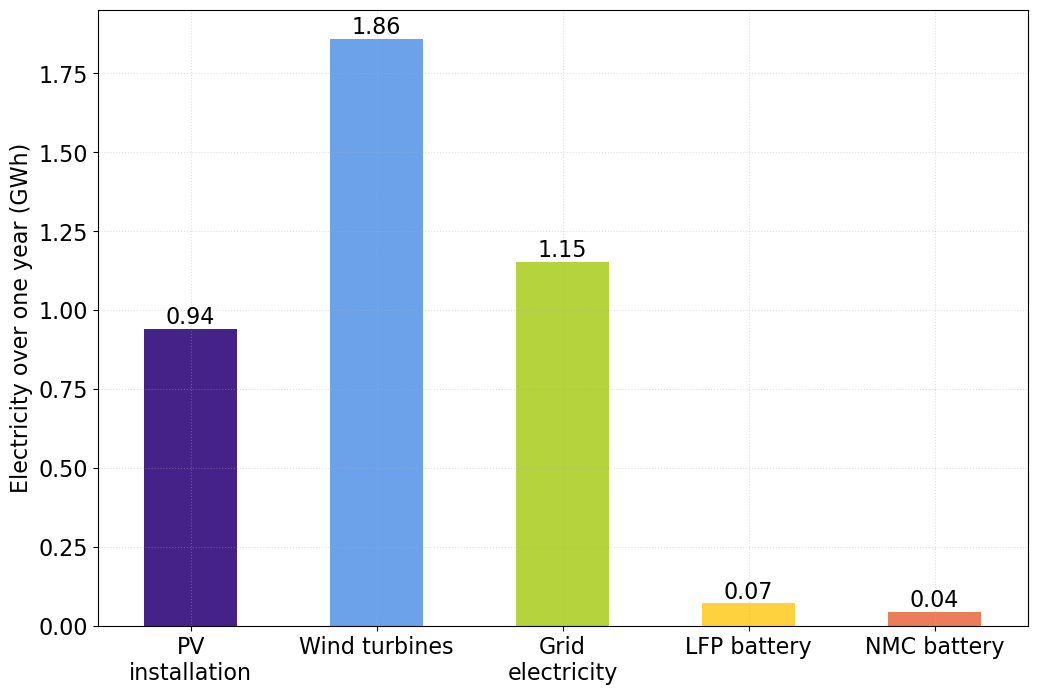

In [36]:
Scores = [sum(electric_solar)/1000000, sum(electric_wind)/1000000, sum(electric_grid_cons)/1000000, sum(electric_lfp_dis)/1000000, sum(electric_nmc_dis)/1000000]

score_series = pd.Series(Scores)

x_labels = ['PV\ninstallation', 'Wind turbines', 'Grid\nelectricity', 'LFP battery', 'NMC battery']

# Plot the figure.
plt.figure(figsize=(12, 8))
fig = score_series.plot(kind='bar', color =['#442288', '#6CA2EA', '#B5D33D', '#FED23F', '#EB7D5B'])
fig.set_xticklabels(x_labels, fontsize=16)
fig.bar_label(fig.containers[0], label_type='edge', fontsize=16, fmt = '%.2f')
plt.ylabel("Electricity over one year (GWh)", fontsize=16)
#plt.title("Electric quantities for RPZ in 2022")
plt.xticks(rotation = 360) 
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.2f}'.format(x) for x in current_values], fontsize=16)
plt.grid(linestyle='dotted',alpha=0.4)
plt.show()

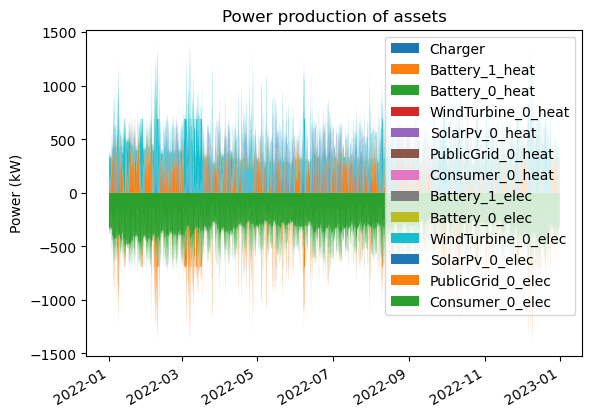

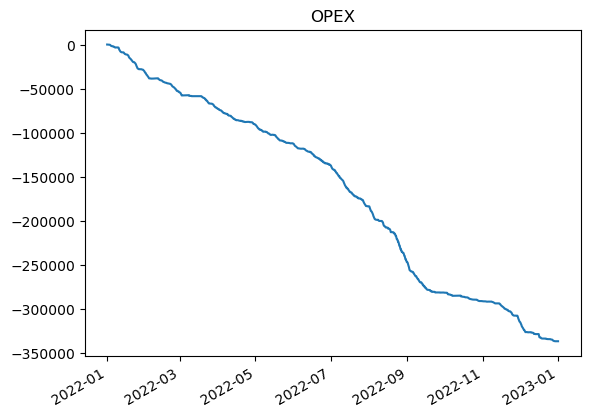

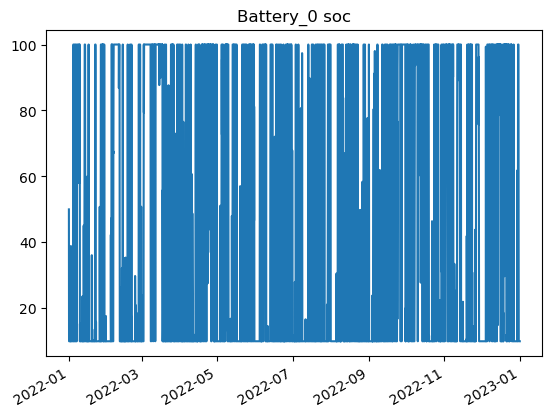

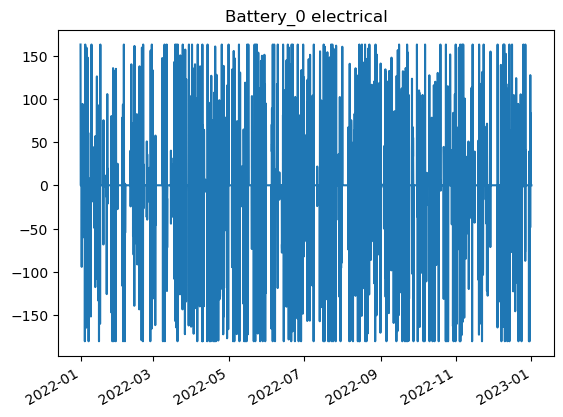

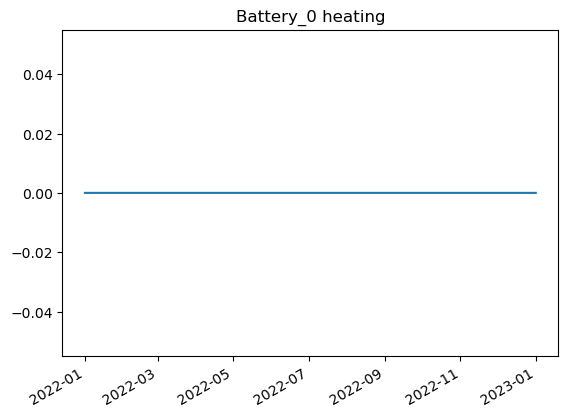

In [37]:
log_micro(mordor, log_dir)

plot_files(log_dir)

# 3. Preparation and LCA

After the asset sizes are determined and the electricity generation and storage is defined, the LCA and LCOE calulation is prepared. First, additional assumptions about the lifetime are needed. Second, the cradle-to-gate asset datasets need to be harmonized with the asset sizes. Further description in terms of technology are required, e.g. for the LCA and LCOE, a particular battery chemistry is required whereas for the design and optimization framework, a generic description such as 'battery ' is sufficient. Therefore, for example energy densities are included.

In a subsequent step, the life cycle inventories are derived from the ecoinvent database or literature (see publication for further information). At the same time, the climate change impact per produced/stored kWh is calculated (IPCC 2013, climate change, global warming potential GWP100a). In a last step, the climate change impact are normalized per functional unit and calculated for each hour over the year 2022.

In [38]:
#Calculation of lifetime electricity generation
pv_years = mordor.assets[2].lifetime
wind_years = mordor.assets[3].lifetime
m_wind = 1087500 #kg weight including the nacelle (61,000 kg), the tower (165,000 kg), the rotor (37,000 kg), the foundation (805,000 kg) and three blades (each 6,500 kg); source: ecoinvent 3.8 dataset
lfp_years = 19
nmc_years = 18
es_years = 25

pv_el = pv_years*sum(electric_solar)
lfp_el = lfp_years*sum(electric_lfp_dis)
nmc_el = nmc_years*sum(electric_nmc_dis)
wind_el = wind_years*sum(electric_wind)

#weight of PV installation per kWp (assumption: 4.5kWp = 21.5 kg, source: https://www.perma-batteries.com/en/product/self-consumption-kit-3kwp-fronius/)
wpv = 1*21.5/4.5

print(pv_years)
print(wind_years)
print(pv_el)
print(lfp_el)
print(nmc_el)
print(wind_el)
print(wpv)

25
25
23507255.37481446
1338658.1793144054
795230.3415296492
46480714.824816704
4.777777777777778


In [39]:
#Capacity of 1 kg of battery
# https://doi.org/10.3390/batteries5020048
    # Data originate from Notter D. A., Gauch M., Widmer R., Wäger P., Stamp A., Zah R. and Althaus H.-J. (2010)
    # Contribution of Li-ion batteries to the environmental impact of electric vehicles. In: Environmental Science & Technology.
    # battery capacity: 0.114 kWh/kg battery
#Density for lfp: http://dx.doi.org/10.1016/j.jclepro.2015.06.021
density = {"nca":0.1414, "nmc111":0.143, "nmc811":0.114, "nimh":0.114, "lead-acid":0.114, "nca":0.114, "nacl":0.114, "lfp":0.125} #initial LFP energy density: 0.125
#C_bat = 1*1/0.114

#    if Bat_type == 'NaCl':
#        C_bat = 1*1/0.116
#    elif Bat_type == 'NiMH':
#        C_bat = 1*1/0.075
#    else:
#        C_bat = 1*1/0.114

print(density['lfp'])
print(density['nmc111'])

0.125
0.143


In [40]:
pv_inst=[act for act in eidb if 'photovoltaic' in act["name"]
                and 'electricity' not in act['name']
                and 'installation' in act['name']
                and 'market' not in act['name']
                and 'on roof' in act['name']
                and 'single-Si' in act['name']
                and 'mounted' in act['name']
                and 'CH' not in act['location']
                ][0]
print(pv_inst)
print(type(pv_inst))

lca_pv = bw.LCA({pv_inst:1}, ipcc)
lca_pv.lci()
lca_pv.lcia()
lca_pv.score

'photovoltaic slanted-roof installation, 3kWp, single-Si, panel, mounted, on roof' (unit, RoW, None)
<class 'bw2data.backends.peewee.proxies.Activity'>


7564.796061531411

In [41]:
pvrcl1 =[act for act in pvlci if 'Treatment, c-Si PV module' in act['name']][0]
print(pvrcl1)

pvrcl2 =[act for act in pvlci if 'Glass cullets, recovered from c-Si PV module treatment' in act['name']][0]
print(pvrcl2)

pvrcl3 =[act for act in pvlci if 'Aluminium scrap, recovered from c-Si PV module treatment' in act['name']][0]
print(pvrcl3)

pvrcl4 =[act for act in pvlci if 'Copper scrap, recovered from c-Si PV module treatment' in act['name']][0]
print(pvrcl4)

'Treatment, c-Si PV module {RER}' (kilogramm, RER, None)
'Glass cullets, recovered from c-Si PV module treatment {RER}' (kilogramm, RER, None)
'Aluminium scrap, recovered from c-Si PV module treatment {RER}' (kilogramm, RER, None)
'Copper scrap, recovered from c-Si PV module treatment {RER}' (kilogramm, RER, None)


In [42]:
pvrcl1 =[act for act in pvlci if 'Treatment, c-Si PV module' in act['name']][0]
#print(pvrcl1)

pvrcl2 =[act for act in pvlci if 'Glass cullets, recovered from c-Si PV module treatment' in act['name']][0]
#print(pvrcl2)

pvrcl3 =[act for act in pvlci if 'Aluminium scrap, recovered from c-Si PV module treatment' in act['name']][0]
#print(pvrcl3)

pvrcl4 =[act for act in pvlci if 'Copper scrap, recovered from c-Si PV module treatment' in act['name']][0]
#print(pvrcl4)

#Cradle-to-gate impacts of single-Si PV installation (kg CO2eq/765 kwp)
lca_pv = bw.LCA({pv_inst:(es_years/pv_years)/3*pv_cap, pvrcl1:(es_years/pv_years)*pv_cap*wpv, pvrcl2:(es_years/pv_years)*pv_cap*wpv, pvrcl3:(es_years/pv_years)*pv_cap*wpv, pvrcl4:(es_years/pv_years)*pv_cap*wpv}, ipcc)
#lca_pv = bw.LCA({pv_inst:1/3*pv_cap}, ipcc)
lca_pv.lci()
lca_pv.lcia()
lca_pv.score

1934825.3944090523

In [43]:
#Cradle-to-grave emissions of single-Si PV installation (kg CO2eq/kWh pv electricity)
cc_pv = lca_pv.score/pv_el
print(cc_pv)

0.08230758391649641


In [44]:
#Climate change of 1 kWh electricity from BE grid (kg CO2eq/kWh)
elbe=[act for act in eidb if 'electricity, low voltage' in act["name"]
                and 'market' in act['name']
                and 'BE' in act['location']
                ][0]
print(elbe)

lca_begrid = bw.LCA({elbe:1}, ipcc)
lca_begrid.lci()
lca_begrid.lcia()
lca_begrid.score
cc_grid = lca_begrid.score
print(cc_grid)

'market for electricity, low voltage' (kilowatt hour, BE, None)
0.2571749590421913


In [45]:
co2price = pd.read_csv(r'C:\Users\dhuber\OneDrive - Vrije Universiteit Brussel\11_Data\06_Country_data\CC_Electricity_grid_hourly_BE\EMBER_Coal2Clean_EUETSPrices_2022.csv')
co2price['Price/kg']=co2price['Price']/1000
test =co2price[co2price['Date'].str.contains("2022")]
b = (test['Price/kg'].repeat(24)).to_list()

In [46]:
co2grid = pd.read_csv(r'C:\Users\dhuber\OneDrive - Vrije Universiteit Brussel\11_Data\06_Country_data\CC_Electricity_grid_hourly_BE\Carbon_intensity_BE_2022_electricity_map.csv')
co2grid.head()
cc_be_grid =co2grid['carbon_intensity_avg']/1000
print((cc_be_grid))

p= cc_be_grid.tolist()

r=[]
for i1, i2 in zip(p, b):
    r.append(i1*i2)

0       0.26269
1       0.25523
2       0.22457
3       0.19474
4       0.21557
         ...   
8755    0.06375
8756    0.05898
8757    0.06957
8758    0.06656
8759    0.07705
Name: carbon_intensity_avg, Length: 8760, dtype: float64


In [47]:
nmc111 = [act for act in eidb if 'battery production' in act['name']
                    and 'NMC111' in act['name']
                    and 'CN' in act['location']
                    and 'Li-ion' in act['name']][0]

In [48]:
lfp = [act for act in batlci if 'Residential battery module' in act['name']
                            and 'LFP' in act['name']][0]
print(lfp)

nmc = [act for act in batlci if 'Residential battery module' in act['name']
                            and 'NMC' in act['name']][0]
print(nmc)

lfprec =[act for act in batlci if 'recycl' in act['name']
                            and 'LFP' in act['name']][0]
print(lfprec)

nmcrec =[act for act in batlci if 'recycl' in act['name']
                            and 'NMC' in act['name']][0]
print(nmcrec)

'Residential battery module (LFP-C)' (kilogram, GLO, None)
'Residential battery module (NMC-C)' (kilogram, GLO, None)
'LFP battery pack recycling' (kilogram, GLO, None)
'NMC battery pack recycling' (kilogram, GLO, None)


In [49]:
lca_lfp = bw.LCA({lfp:(es_years/lfp_years)*(1*1/density['lfp'])*lfp_cap, lfprec:(es_years/lfp_years)*(1*1/density['lfp'])*lfp_cap}, ipcc)
lca_lfp.lci()
lca_lfp.lcia()
lca_lfp.score

38174.85714320986

In [50]:
#Climate change impact of electricity discharged from an lfp battery (kg CO2eq/kWh discharged electricity)
cc_lfp = lca_lfp.score/lfp_el
print(cc_lfp)


0.02851725536294944


In [51]:
#Validation of LCI from Varlet et al (2020) compared to NMC111 ecoinvent LCI
lca_test_lfp = bw.LCA({lfp:1}, ipcc)
lca_test_lfp.lci()
lca_test_lfp.lcia()
lca_test_lfp.score

lca_test_nmc = bw.LCA({nmc:1}, ipcc)
lca_test_nmc.lci()
lca_test_nmc.lcia()
lca_test_nmc.score

lca_test_nmc111 = bw.LCA({nmc111:1}, ipcc)
lca_test_nmc111.lci()
lca_test_nmc111.lcia()
lca_test_nmc111.score

print(lca_test_lfp.score)
print(lca_test_nmc.score)
print(lca_test_nmc111.score)

12.37456751865739
16.65896198788347
18.20953214109084


In [52]:
#Cradle-to-gate climate change emissions of NMC111 battery (kg CO2eq)
#The functional unit converts the dataset for original 1 kg to the required capacity per kWh via the energy density
lca_nmc = bw.LCA({nmc:(es_years/nmc_years)*(1*1/density['nmc111'])*nmc_cap, nmcrec:(es_years/nmc_years)*(1*1/density['nmc111'])*nmc_cap}, ipcc)
lca_nmc.lci()
lca_nmc.lcia()
lca_nmc.score

48780.85407055051

In [53]:
#Climate change impact of electricity discharged from an NMC battery (kg CO2eq/kWh discharged electricity)
#cc_bat = lca_nmc111.score/bat_el*-1
cc_nmc = lca_nmc.score/nmc_el
print(cc_nmc)

0.06134179183445024


In [54]:
#Cradle-to-gate climate change emissions of wind turbines (kg CO2eq)
#Climate change impact of electricity generated by the wind turbines (kg CO2eq/kWh generated electricity)
#The functional unit converts the dataset of an original wind turbine installation with a capacity of 4.5 GWh to the required size of the capacity provided in the config file.
#lca_wind45 = bw.LCA({wind45:1/4.5*wind_cap}, ipcc)
wind = [act for act in eidb if 'electricity production, wind, 1-3MW turbine, onshore' in act['name']
                    and 'BE' in act['location']][0]
print(wind)

lca_wind = bw.LCA({wind:1}, ipcc)
lca_wind.lci()
lca_wind.lcia()
cc_wind = lca_wind.score
print(cc_wind)

'electricity production, wind, 1-3MW turbine, onshore' (kilowatt hour, BE, None)
0.015549329774351126


In [55]:
#Climate change per kWh of consumed electricity (kg CO2 eq/kWh)
cc_total = cc_pv + cc_lfp + cc_nmc + cc_grid + cc_wind
print(cc_total)

0.4448909199304385


In [56]:
h_cc_pv=[]
for item in electric_solar:
    h_cc_pv.append(item * cc_pv)

h_cc_pv_eur = []
for i1, i2 in zip(h_cc_pv, b):
    h_cc_pv_eur.append(i1*i2)

h_cc_wind=[]
for item in electric_wind:
    h_cc_wind.append(item * cc_wind)

h_cc_wind_eur = []
for i1, i2 in zip(h_cc_wind, b):
    h_cc_wind_eur.append(i1*i2)

h_cc_grid = [a*b for a,b in zip(electric_grid_cons, cc_be_grid)]

h_cc_grid_eur = []
for i1, i2 in zip(h_cc_grid, b):
    h_cc_grid_eur.append(i1*i2)

h_cc_lfp=[]
for item in electric_lfp_dis:
    h_cc_lfp.append(item * cc_lfp)

h_cc_lfp_eur = []
for i1, i2 in zip(h_cc_lfp, b):
    h_cc_lfp_eur.append(i1*i2)

h_cc_nmc=[]
for item in electric_nmc_dis:
    h_cc_nmc.append(item * cc_nmc)

h_cc_nmc_eur = []
for i1, i2 in zip(h_cc_nmc, b):
    h_cc_nmc_eur.append(i1*i2)

e = []
for item in electric_consumer:
    e.append(item*-1)

hccpv_1 = [x / y for x, y in zip(h_cc_pv, e)]
hccwind_1 = [x / y for x, y in zip(h_cc_wind, e)]
hccgrid_1 = [x / y for x, y in zip(h_cc_grid, e)]
hcclfp_1 = [x / y for x, y in zip(h_cc_lfp, e)]
hccnmc_1 = [x / y for x, y in zip(h_cc_nmc, e)]

zipped_total = zip(hccpv_1, hccwind_1, hcclfp_1, hccnmc_1, hccgrid_1)
h_cc_total = [v + w + x + y + z for (v, w, x, y, z) in zipped_total]

hourly_cc = pd.DataFrame({
    'PV': hccpv_1,
    'Wind turbine': hccwind_1,
    'LFP Battery': hcclfp_1,
    'NMC battery': hccnmc_1,
    'BE grid': hccgrid_1,
    'Total': h_cc_total
})
    
hccpveur_1 = [x / y for x, y in zip(h_cc_pv_eur, e)]
hccwindeur_1 = [x / y for x, y in zip(h_cc_wind_eur, e)]
hccgrideur_1 = [x / y for x, y in zip(h_cc_grid_eur, e)]
hcclfpeur_1 = [x / y for x, y in zip(h_cc_lfp_eur, e)]
hccnmceur_1 = [x / y for x, y in zip(h_cc_nmc_eur, e)]

zipped_total = zip(hccpveur_1, hccwindeur_1, hcclfpeur_1, hccnmceur_1, hccgrideur_1)
h_cc_total_eur = [v + w + x + y + z for (v, w, x, y, z) in zipped_total]

hourly_cc_eur = pd.DataFrame({
    'PV': hccpveur_1,
    'Wind turbine': hccwindeur_1,
    'LFP Battery': hcclfpeur_1,
    'NMC battery': hccnmceur_1,
    'BE grid': hccgrideur_1,
    'Total': h_cc_total_eur
})

# 4. LCOE calculation

To calculate the LCOE, the CAPEX of each assets are included. Afterwards, the CAPEX is divided over the functional unit and for each hour over 2022 calculated for each asset. Hereafter, the LCA and LCOE of each assets are summed up and stored in a dictionary, representing the eco-efficiency.

In [57]:
#lcoe calculation
pv_capex = 1000*pv_cap
wind_capex = 1460*(wind_cap*1000)
lfp_capex = 433*lfp_cap
nmc_capex = 443*nmc_cap
#wind_capex = 1400*wind_cap
eur_kwh_grid = 0.23
#source pv_capex: config file Julian
#source lfp_capex: 448$/kWh (1MW/4h), 2020 Grid Energy Storage Technology Cost and Performance Assessment, https://www.pnnl.gov/sites/default/files/media/file/Final%20-%20ESGC%20Cost%20Performance%20Report%2012-11-2020.pdf
#source nmc_capex: 459$/kWh (1MW/4h), 2020 Grid Energy Storage Technology Cost and Performance Assessment, https://www.pnnl.gov/sites/default/files/media/file/Final%20-%20ESGC%20Cost%20Performance%20Report%2012-11-2020.pdf
#source wind_capex: Renewable Power Generation - Costs in 2020, p. 57. Value: 1,515 USD/kW in 2020 (Weighted average of total installed costs for wind projects in Europe) https://www.irena.org/publications/2021/Jun/Renewable-Power-Costs-in-2020
#source electricity price: oupbouw gemiddelde commerciele electriciteitsprijs, https://dashboard.vreg.be/report/DMR_Prijzen_elektriciteit.html

#lcoe of different assets
lcoe_pv = pv_capex/pv_el
lcoe_wind = wind_capex/wind_el
lcoe_lfp = lfp_capex/lfp_el
lcoe_nmc = nmc_capex/nmc_el
#lcoe_wind = wind_capex/wind_el
lcoe_grid = eur_kwh_grid

h_lcoe_pv=[]
for item in electric_solar:
    h_lcoe_pv.append(item * lcoe_pv)

h_lcoe_wind=[]
for item in electric_wind:
    h_lcoe_wind.append(item * lcoe_wind)

h_lcoe_lfp=[]
for item in electric_lfp_dis:
    h_lcoe_lfp.append(item * lcoe_lfp)

h_lcoe_nmc=[]
for item in electric_nmc_dis:
    h_lcoe_nmc.append(item * lcoe_nmc)

#Source for prices/MWh of BE grid mix: https://my.elexys.be/MarketInformation/SpotBelpex.aspx
#The belpex electricity price represents only the energy costs. These values are adjusted to also include distribution, transmission and other charges. As a reference, the prices of January 2019 was used (https://dashboard.vreg.be/report/DMR_Prijzen_elektriciteit.html)
eurmwh = pd.read_csv(r'C:\Users\dhuber\OneDrive - Vrije Universiteit Brussel\11_Data\06_Country_data\BE_hourly_electricity_costs\2022\BE_Day-ahead Prices_UTC_2022.csv')
eur_be_grid =(eurmwh['Day-ahead Price [EUR/MWh]']/1000)
h_lcoe_grid = [a*b for a,b in zip(electric_grid_cons, eur_be_grid)]

hlcoepv_1 = [x / -y for x, y in zip(h_lcoe_pv, electric_consumer)]
hlcoewind_1 = [x / -y for x, y in zip(h_lcoe_wind, electric_consumer)]
hlcoegrid_1 = [x / -y for x, y in zip(h_lcoe_grid, electric_consumer)]
hlcoelfp_1 = [x / -y for x, y in zip(h_lcoe_lfp, electric_consumer)]
hlcoenmc_1 = [x / -y for x, y in zip(h_lcoe_nmc, electric_consumer)]

zipped_total_lcoe = zip(hlcoepv_1, hlcoewind_1, hlcoegrid_1, hlcoelfp_1, hlcoenmc_1)
h_lcoe_total = [v + w + x + y + z for (v, w, x, y, z) in zipped_total_lcoe]

hourly_lcoe = pd.DataFrame({
    'PV': hlcoepv_1,
    'Wind': hlcoewind_1,
    'BE grid': hlcoegrid_1,
    'LFP': hlcoelfp_1,
    'NMC': hlcoenmc_1,
    'Total': h_lcoe_total
})

q= eur_be_grid.tolist()

cost_year = pv_capex/pv_years + wind_capex/wind_years + lfp_capex/lfp_years + nmc_capex/nmc_years + (mean(q)*sum(electric_grid_cons))
avg_cost = cost_year/sum(electric_grid_cons)
print(avg_cost)

0.3201357836816511


In [58]:
#Rating of MAMCA objectives by different stakeholders

#sg2c=0.9 #Weighting criteria of DSO for decrease of electricity bill
#sg2e=0.1 #Weighting criteria of DSO for emission reduction
#sg1c=0.1 #Weighting criteria of real estate developer for decrease of electricity bill
#sg1e=0.9 #Weighting criteria of real estate developer for emission reduction

w = 0.5

sg2c= w #Weighting criteria of DSO for decrease of electricity bill
sg2e= (1-w) #Weighting criteria of DSO for emission reduction
sg1c= (1-w) #Weighting criteria of real estate developer for decrease of electricity bill
sg1e= w #Weighting criteria of real estate developer for emission reduction

cc_week = pd.DataFrame(list(zip(h_cc_total_eur[1728:1896], h_cc_total_eur[4080:4248], h_cc_total_eur[6264:6432], h_cc_total_eur[8448:8616])),
               columns =['Spring', 'Summer', 'Autumn', 'Winter'])

lcoe_week = pd.DataFrame(list(zip(h_lcoe_total[1728:1896], h_lcoe_total[4080:4248], h_lcoe_total[6264:6432], h_lcoe_total[8448:8616])),
               columns =['Spring', 'Summer', 'Autumn', 'Winter'])

eefhouse=pd.DataFrame({'Spring_lcoe':lcoe_week['Spring'],
                        'Spring_cc':cc_week['Spring'],
                        'Summer_lcoe': lcoe_week['Summer'],
                        'Summer_cc':cc_week['Summer'],
                        'Autumn_lcoe':lcoe_week['Autumn'],
                        'Autumn_cc':cc_week['Autumn'],
                        'Winter_lcoe':lcoe_week['Winter'],
                        'Winter_cc':cc_week['Winter']})

eef_sg2=eefhouse.mul({'Spring_lcoe': sg2c, 'Spring_cc': sg2e, 'Summer_lcoe': sg2c, 'Summer_cc': sg2e, 'Autumn_lcoe': sg2c, 'Autumn_cc': sg2e, 'Winter_lcoe': sg2c, 'Winter_cc': sg2e})
eef3_sg2=pd.DataFrame({'ef_spring': eef_sg2['Spring_lcoe']+eef_sg2['Spring_cc'],
                    'ef_summer': eef_sg2['Summer_lcoe']+eef_sg2['Summer_cc'],
                    'ef_autumn': eef_sg2['Autumn_lcoe']+eef_sg2['Autumn_cc'],
                    'ef_winter': eef_sg2['Winter_lcoe']+eef_sg2['Winter_cc']})

eef_sg1=eefhouse.mul({'Spring_lcoe': sg1c, 'Spring_cc': sg1e, 'Summer_lcoe': sg1c, 'Summer_cc': sg1e, 'Autumn_lcoe': sg1c, 'Autumn_cc': sg1e, 'Winter_lcoe': sg1c, 'Winter_cc': sg1e})
eef3_sg1=pd.DataFrame({'ef_spring': eef_sg1['Spring_lcoe']+eef_sg1['Spring_cc'],
                    'ef_summer': eef_sg1['Summer_lcoe']+eef_sg1['Summer_cc'],
                    'ef_autumn': eef_sg1['Autumn_lcoe']+eef_sg1['Autumn_cc'],
                    'ef_winter': eef_sg1['Winter_lcoe']+eef_sg1['Winter_cc']})

grid_cc_lcoe = [x + y for x, y in zip(h_cc_grid_eur, h_lcoe_grid)]
dates = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31')
num_repeats = 24
ec_2022=pd.DataFrame({'CF':h_cc_total, 'LCOE': h_lcoe_total})
bau_ec2022=pd.DataFrame({'CF':p, 'LCOE':eur_be_grid})
g=pd.DataFrame()
g['Timesteps']=timestep
g['Date']=pd.DataFrame(dates.repeat(num_repeats),columns=['date'])
g['Hour']=pd.to_datetime(g['Timesteps']).dt.strftime('%H:%M:%S')
g['SG2']=ec_2022['CF'].mul(sg2c)+ec_2022['LCOE'].mul(sg2e)
g['SG1']=ec_2022['CF'].mul(sg1c)+ec_2022['LCOE'].mul(sg1e)
g['RPZ']=ec_2022['CF']+ec_2022['LCOE']
g['BAU–BE']=bau_ec2022['CF']+bau_ec2022['LCOE']

print(g.head())

            Timesteps       Date      Hour       SG2       SG1       RPZ  \
0 2022-01-01 00:00:00 2022-01-01  00:00:00  0.049265  0.049265  0.098529   
1 2022-01-01 01:00:00 2022-01-01  01:00:00  0.053814  0.053814  0.107627   
2 2022-01-01 02:00:00 2022-01-01  02:00:00  0.071325  0.071325  0.142650   
3 2022-01-01 03:00:00 2022-01-01  03:00:00  0.066562  0.066562  0.133123   
4 2022-01-01 04:00:00 2022-01-01  04:00:00  0.061504  0.061504  0.123009   

    BAU–BE  
0  0.32976  
1  0.33034  
2  0.27548  
3  0.23241  
4  0.25527  


# 5. Final results

The following part contains the code used to compile subplots for the power profil, the LCA, the LCOE and the eco-efficiency of four selected weeks in 2022 for the Research Park in Zellik, Belgium.

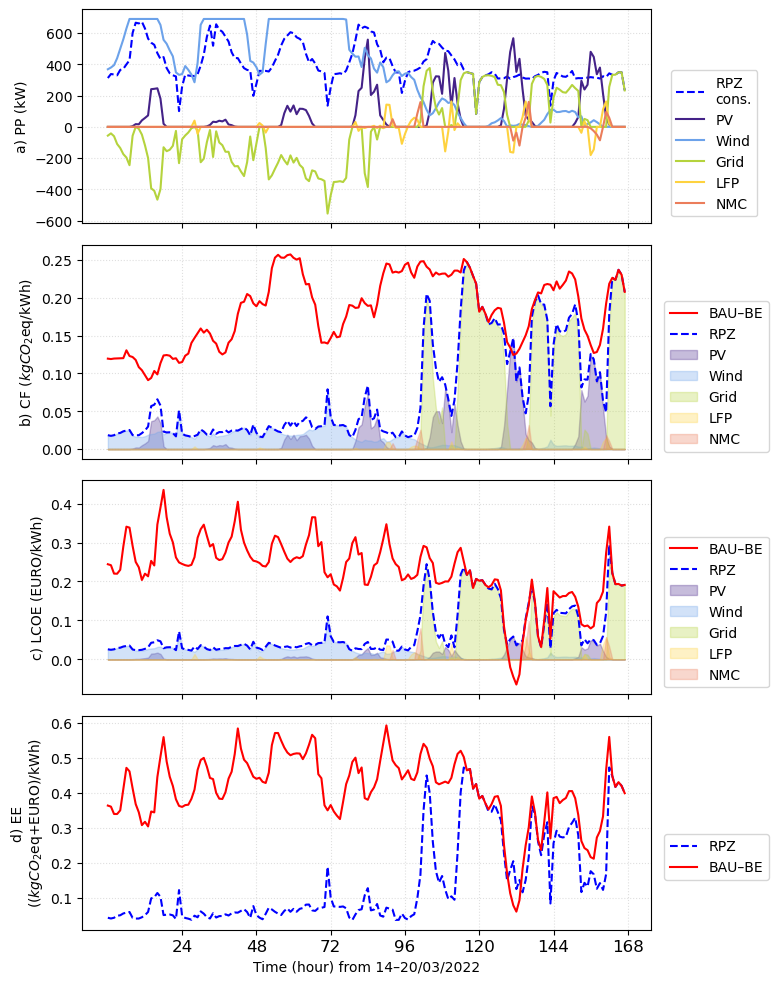

In [59]:
#Spring
from pickle import TRUE

ser=pd.Series(range(168))

cc_week = pd.DataFrame(list(zip(h_cc_total[1728:1896], h_cc_total[4080:4248], h_cc_total[6264:6432], h_cc_total[8448:8616])),
               columns =['Spring', 'Summer', 'Autumn', 'Winter'])

lcoe_week = pd.DataFrame(list(zip(h_lcoe_total[1728:1896], h_lcoe_total[4080:4248], h_lcoe_total[6264:6432], h_lcoe_total[8448:8616])),
               columns =['Spring', 'Summer', 'Autumn', 'Winter'])

cc_spring = pd.DataFrame(list(zip(hccpv_1[1728:1896], hccwind_1[1728:1896], hccgrid_1[1728:1896], hcclfp_1[1728:1896], hccnmc_1[1728:1896])),
               columns =['PV', 'Wind', 'Grid', 'LFP', 'NMC'])

lcoe_spring = pd.DataFrame(list(zip(hlcoepv_1[1728:1896], hlcoewind_1[1728:1896], hlcoegrid_1[1728:1896], hlcoelfp_1[1728:1896], hlcoenmc_1[1728:1896])),
               columns =['PV', 'Wind', 'Grid', 'LFP', 'NMC'])

fig, axs = plt.subplots(4, 1, figsize=(8, 10), sharex='col', tight_layout=TRUE)
axs[0].plot([i*-1 for i in electric_consumer[1728:1896]], label='RPZ\ncons.', color='b', linestyle='--')
axs[0].plot(electric_solar[1728:1896], label='PV', color='#442288')
axs[0].plot(electric_wind[1728:1896], label='Wind', color='#6CA2EA')
axs[0].plot(electric_grid_tot[1728:1896], label='Grid', color='#B5D33D')
axs[0].plot(electric_lfp_tot[1728:1896], label='LFP', color='#FED23F')
axs[0].plot(electric_nmc_tot[1728:1896], label='NMC', color='#EB7D5B')
axs[0].set_ylabel('a) PP (kW)')
#axs[0].set_xlabel('Hourly timestep of one week')
axs[0].legend()
axs[0].legend(bbox_to_anchor=(1.2, 0.0), loc='lower right', ncol= 1, fontsize=10)
#axs[0].set_title('a) Power production of the RPZ in spring')
axs[0].set_xticks([24, 48, 72, 96, 120, 144, 168]) 
axs[0].set_xticklabels([24, 48, 72, 96, 120, 144, 168], fontsize=12)
axs[0].grid(linestyle='dotted',alpha=0.4)

axs[1].plot(p[1728:1896], label='BAU–BE', color='r', zorder=8)
axs[1].plot((ser),(cc_week['Spring']), label='RPZ', color='b', linestyle='--', zorder=7)
#axs[1].axhline(y=cc_total, color='y', linestyle='-.', label='Avg. energy\nsystem')
#axs[1].axhline(y=cc_grid, color='r', linestyle='-', laBbel='Avg. BE\ngrid mix')
axs[1].fill_between((ser), (cc_spring['PV']), color='#442288', alpha=0.3, zorder=1, label='PV')
axs[1].fill_between((ser), (cc_spring['Wind']), color='#6CA2EA', alpha=0.3, zorder=2, label='Wind')
axs[1].fill_between((ser), (cc_spring['Grid']), color='#B5D33D', alpha=0.3, zorder=3, label='Grid')
axs[1].fill_between((ser), (cc_spring['LFP']), color='#FED23F', alpha=0.3, zorder=4, label='LFP')
axs[1].fill_between((ser), (cc_spring['NMC']), color='#EB7D5B', alpha=0.3, zorder=5, label='NMC')
axs[1].set_ylabel('b) CF ($kgCO_2$eq/kWh)')
#axs[1].set_xlabel('Hourly timestep of one week')
axs[1].legend()
axs[1].legend(bbox_to_anchor=(1.22, 0.0), loc='lower right', ncol= 1, fontsize=10)
#axs[1].set_title('b) Carbon footprint of the RPZ in spring')
axs[1].set_xticks([24, 48, 72, 96, 120, 144, 168]) 
axs[1].set_xticklabels([24, 48, 72, 96, 120, 144, 168], fontsize=12)
axs[1].grid(linestyle='dotted',alpha=0.4)

#print(lcoe_week)
axs[2].plot(q[1728:1896], label='BAU–BE', color='r', zorder=8)
axs[2].plot((ser),(lcoe_week['Spring']), label='RPZ', color='b', linestyle='--', zorder=7)
#axs[2].axhline(y=avg_cost, color='y', linestyle='-.', label='Avg. energy\nsystem')
#axs[2].axhline(y=eur_kwh_grid, color='r', linestyle='-', label='Avg. BE\ngrid price')
axs[2].fill_between((ser), (lcoe_spring['PV']), color='#442288', alpha=0.3, zorder=1, label='PV')
axs[2].fill_between((ser), (lcoe_spring['Wind']), color='#6CA2EA', alpha=0.3, zorder=2, label='Wind')
axs[2].fill_between((ser), (lcoe_spring['Grid']), color='#B5D33D', alpha=0.3, zorder=3, label='Grid')
axs[2].fill_between((ser), (lcoe_spring['LFP']), color='#FED23F', alpha=0.3, zorder=4, label='LFP')
axs[2].fill_between((ser), (lcoe_spring['NMC']), color='#EB7D5B', alpha=0.3, zorder=5, label='NMC')
axs[2].set_ylabel('c) LCOE (EURO/kWh)')
#axs[2].set_xlabel('Hourly timestep of one week')
axs[2].legend()
axs[2].legend(bbox_to_anchor=(1.22, 0.0), loc='lower right', ncol= 1, fontsize=10)
#axs[2].set_title('c) Levelized cost of electricity of the RPZ in spring')
axs[2].set_xticks([24, 48, 72, 96, 120, 144, 168]) 
axs[2].set_xticklabels([24, 48, 72, 96, 120, 144, 168], fontsize=12)
axs[2].grid(linestyle='dotted',alpha=0.4)

#Stakeholder group 1: Energy cooperatives, real estate developer, local government
#Stakeholder group 2: Businesses, DSO
#axs[3].plot((ser),(eef3_sg1['ef_spring']), label='SG1', linestyle="--", color='#000000', zorder=7)
#axs[3].plot((ser),(eef3_sg2['ef_spring']), label='SG2', linestyle= ":", color='#000000', zorder=7)
axs[3].plot((ser),(g['RPZ'][1728:1896]), label='RPZ', color='b', linestyle='--', zorder=7)
axs[3].plot((ser),(g['BAU–BE'][1728:1896]), label='BAU–BE', color='r', zorder=7)
axs[3].set_ylabel('d) EE\n(($kgCO_2$eq+EURO)/kWh)')
axs[3].set_xlabel('Time (hour) from 14–20/03/2022')
axs[3].legend()
axs[3].legend(bbox_to_anchor=(1.22, 0.2), loc='lower right', ncol= 1, fontsize=10)
#axs[3].set_title('d) Eco-efficiency of the RPZ in spring')
axs[3].set_xticks([24, 48, 72, 96, 120, 144, 168]) 
axs[3].set_xticklabels([24, 48, 72, 96, 120, 144, 168], fontsize=12)
axs[3].grid(linestyle='dotted',alpha=0.4)

fig.tight_layout()
#plt.rcParams.update({'font.size': 12})
fig.subplots_adjust(hspace=0.1, wspace=0.06)
plt.show()
plt.rcParams["figure.dpi"] = 500

#alpha=0.3
#zorder=

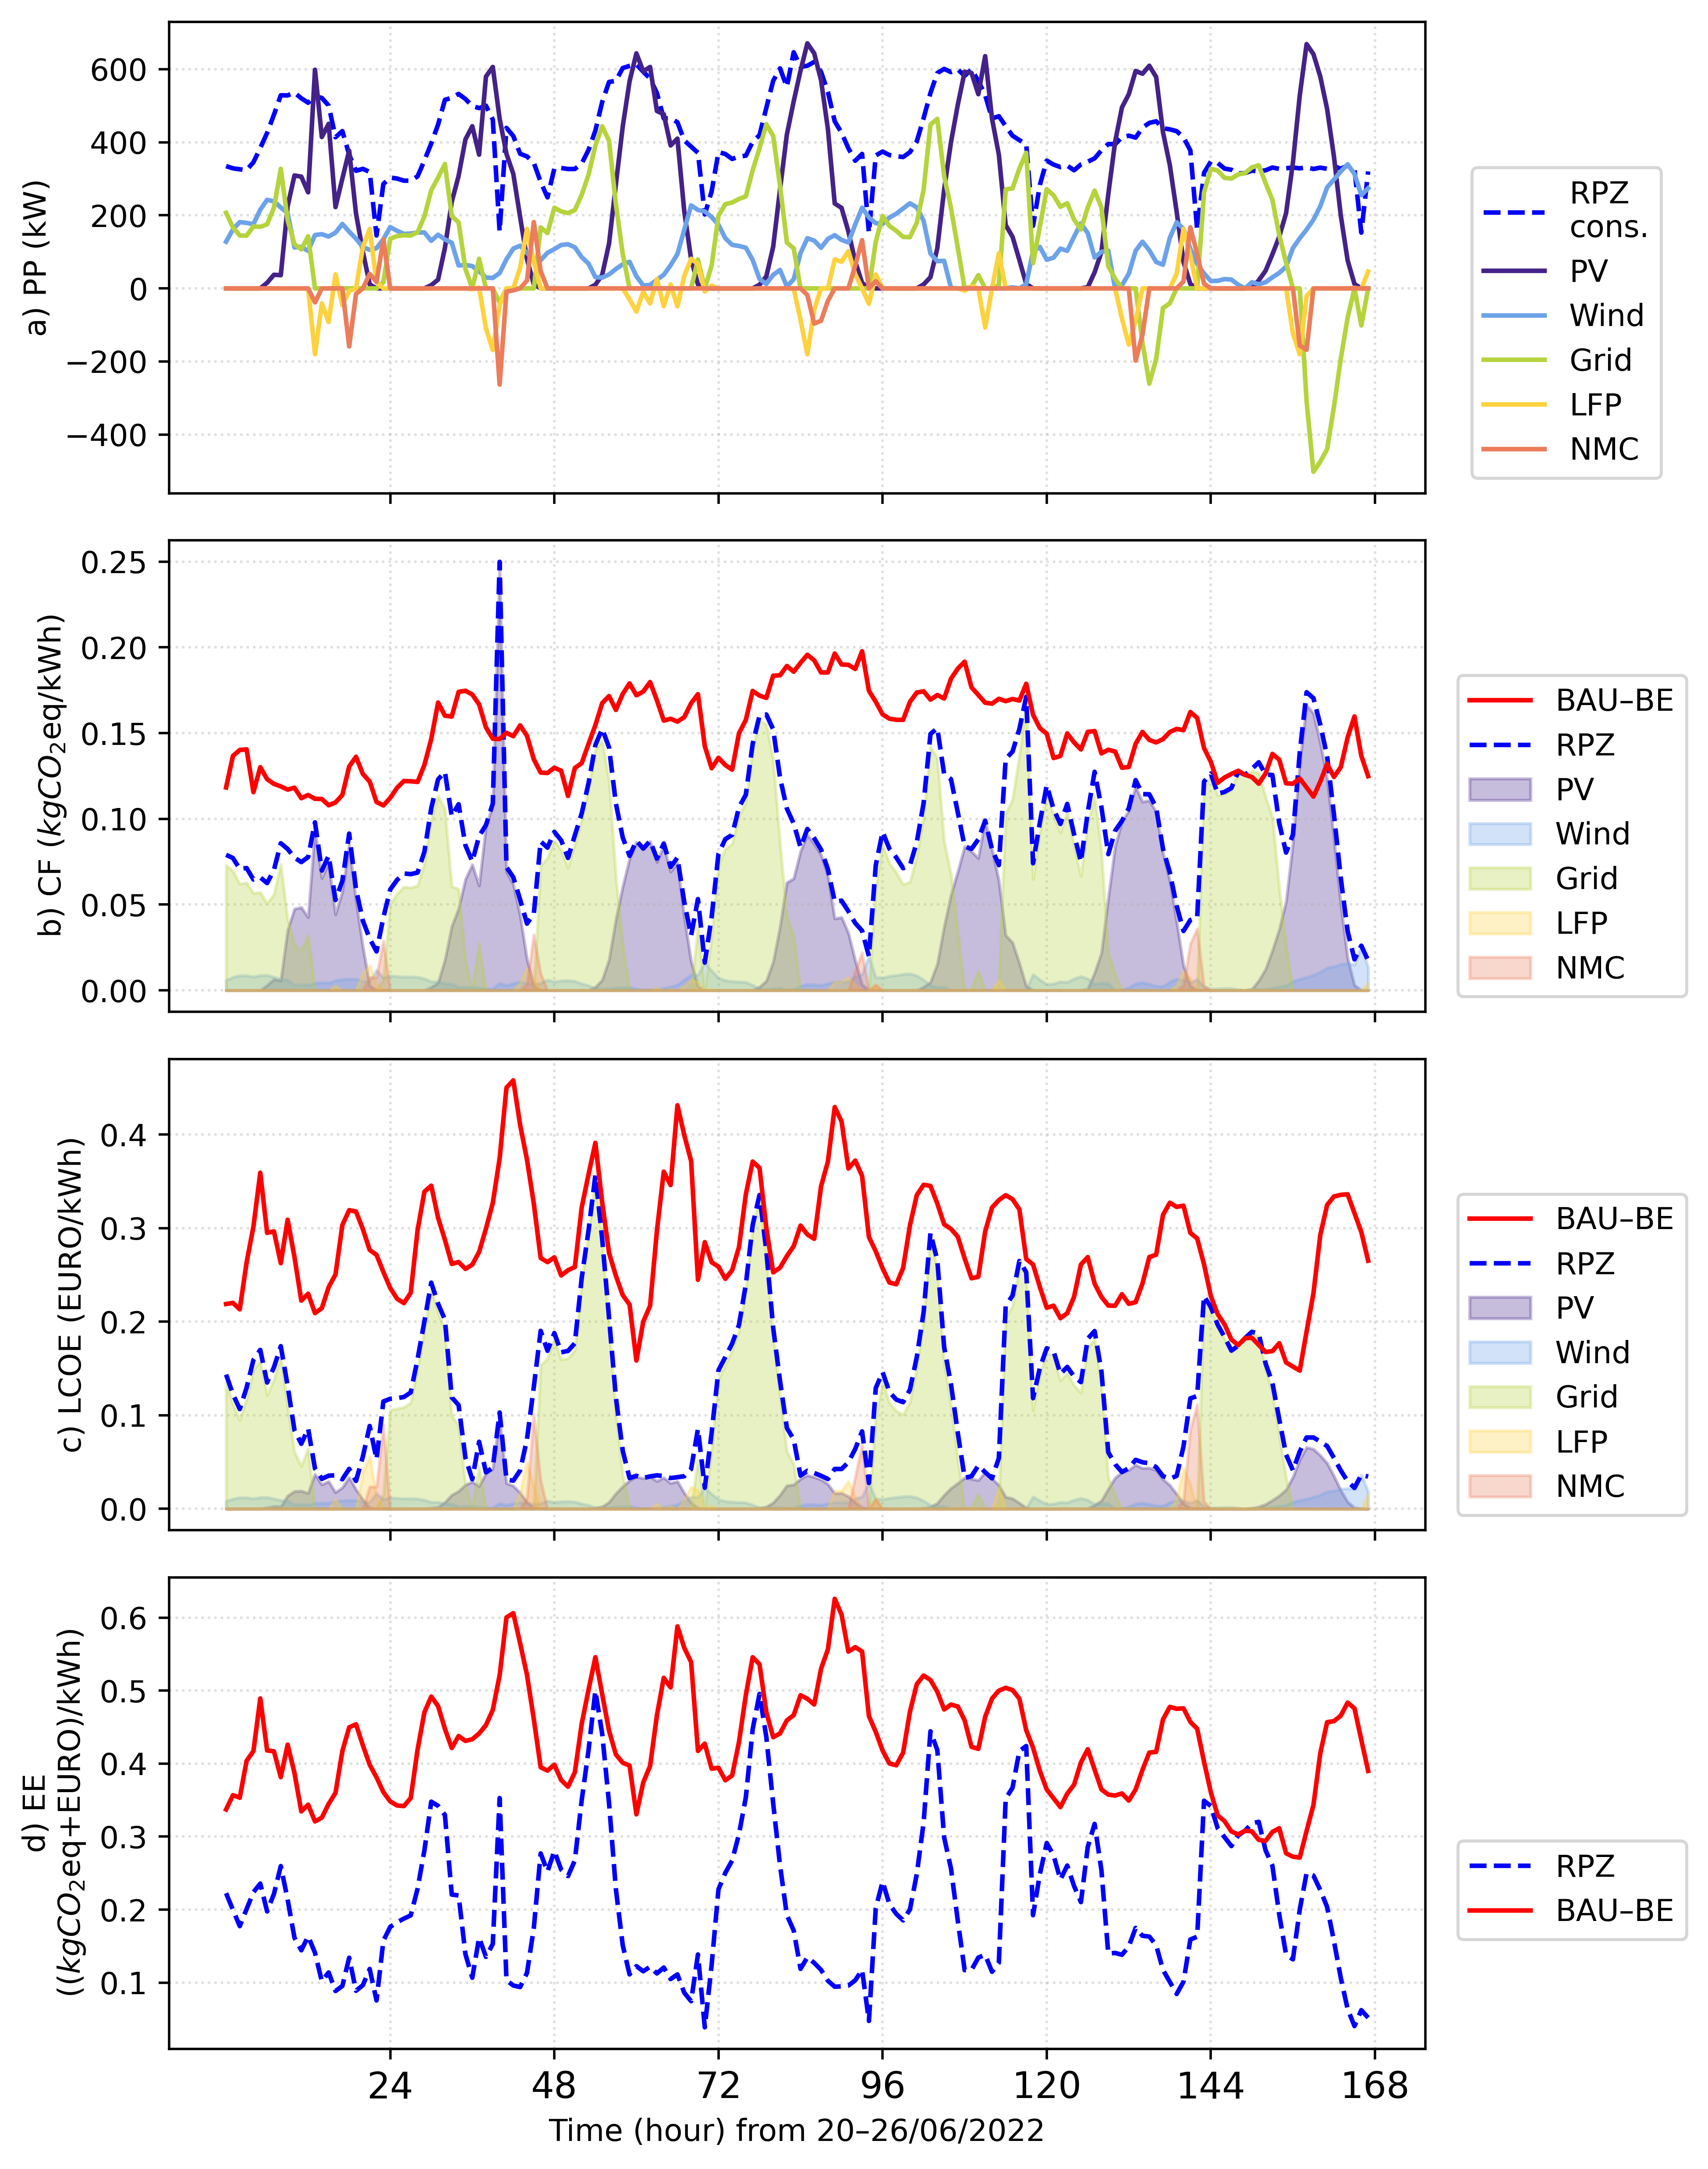

In [60]:
#Summer
from pickle import TRUE

ser=pd.Series(range(168))

cc_week = pd.DataFrame(list(zip(h_cc_total[1728:1896], h_cc_total[4080:4248], h_cc_total[6264:6432], h_cc_total[8448:8616])),
               columns =['Spring', 'Summer', 'Autumn', 'Winter'])

lcoe_week = pd.DataFrame(list(zip(h_lcoe_total[1728:1896], h_lcoe_total[4080:4248], h_lcoe_total[6264:6432], h_lcoe_total[8448:8616])),
               columns =['Spring', 'Summer', 'Autumn', 'Winter'])

cc_summer = pd.DataFrame(list(zip(hccpv_1[4080:4248], hccwind_1[4080:4248], hccgrid_1[4080:4248], hcclfp_1[4080:4248], hccnmc_1[4080:4248])),
               columns =['PV', 'Wind', 'Grid', 'LFP', 'NMC'])

lcoe_summer = pd.DataFrame(list(zip(hlcoepv_1[4080:4248], hlcoewind_1[4080:4248], hlcoegrid_1[4080:4248], hlcoelfp_1[4080:4248], hlcoenmc_1[4080:4248])),
               columns =['PV', 'Wind', 'Grid', 'LFP', 'NMC'])

fig, axs = plt.subplots(4, 1, figsize=(8, 10), sharex='col', tight_layout=TRUE)
axs[0].plot([i*-1 for i in electric_consumer[4080:4248]], label='RPZ\ncons.', color='b', linestyle='--')
axs[0].plot(electric_solar[4080:4248], label='PV', color='#442288')
axs[0].plot(electric_wind[4080:4248], label='Wind', color='#6CA2EA')
axs[0].plot(electric_grid_tot[4080:4248], label='Grid', color='#B5D33D')
axs[0].plot(electric_lfp_tot[4080:4248], label='LFP', color='#FED23F')
axs[0].plot(electric_nmc_tot[4080:4248], label='NMC', color='#EB7D5B')
axs[0].set_ylabel('a) PP (kW)')
#axs[0].set_xlabel('Hourly timestep of one week')
axs[0].legend()
axs[0].legend(bbox_to_anchor=(1.2, 0.0), loc='lower right', ncol= 1, fontsize=10)
#axs[0].set_title('a) Power production of the RPZ in summer')
axs[0].set_xticks([24, 48, 72, 96, 120, 144, 168]) 
axs[0].set_xticklabels([24, 48, 72, 96, 120, 144, 168], fontsize=12)
axs[0].grid(linestyle='dotted',alpha=0.4)

axs[1].plot(p[4080:4248], label='BAU–BE', color='r', linestyle='-', zorder=8)
axs[1].plot((ser),(cc_week['Summer']), label='RPZ', color='b', linestyle='--', zorder=7)
#axs[1].axhline(y=cc_total, color='y', linestyle='-.', label='Avg. energy\nsystem')
#axs[1].axhline(y=cc_grid, color='r', linestyle='-', laBbel='Avg. BE\ngrid mix')
axs[1].fill_between((ser), (cc_summer['PV']), color='#442288', alpha=0.3, zorder=1, label='PV')
axs[1].fill_between((ser), (cc_summer['Wind']), color='#6CA2EA', alpha=0.3, zorder=2, label='Wind')
axs[1].fill_between((ser), (cc_summer['Grid']), color='#B5D33D', alpha=0.3, zorder=3, label='Grid')
axs[1].fill_between((ser), (cc_summer['LFP']), color='#FED23F', alpha=0.3, zorder=4, label='LFP')
axs[1].fill_between((ser), (cc_summer['NMC']), color='#EB7D5B', alpha=0.3, zorder=5, label='NMC')
axs[1].set_ylabel('b) CF ($kgCO_2$eq/kWh)')
#axs[1].set_xlabel('Hourly timestep of one week')
axs[1].legend()
axs[1].legend(bbox_to_anchor=(1.22, 0.0), loc='lower right', ncol= 1, fontsize=10)
#axs[1].set_title('b) Carbon footprint of the RPZ in summer')
axs[1].set_xticks([24, 48, 72, 96, 120, 144, 168]) 
axs[1].set_xticklabels([24, 48, 72, 96, 120, 144, 168], fontsize=12)
axs[1].grid(linestyle='dotted',alpha=0.4)

#print(lcoe_week)
axs[2].plot(q[4080:4248], label='BAU–BE', color='r', linestyle='-', zorder=8)
axs[2].plot((ser),(lcoe_week['Summer']), label='RPZ', color='b', linestyle='--', zorder=7)
#axs[2].axhline(y=avg_cost, color='y', linestyle='-.', label='Avg. energy\nsystem')
#axs[2].axhline(y=eur_kwh_grid, color='r', linestyle='-', label='Avg. BE\ngrid price')
axs[2].fill_between((ser), (lcoe_summer['PV']), color='#442288', alpha=0.3, zorder=1, label='PV')
axs[2].fill_between((ser), (lcoe_summer['Wind']), color='#6CA2EA', alpha=0.3, zorder=2, label='Wind')
axs[2].fill_between((ser), (lcoe_summer['Grid']), color='#B5D33D', alpha=0.3, zorder=3, label='Grid')
axs[2].fill_between((ser), (lcoe_summer['LFP']), color='#FED23F', alpha=0.3, zorder=4, label='LFP')
axs[2].fill_between((ser), (lcoe_summer['NMC']), color='#EB7D5B', alpha=0.3, zorder=5, label='NMC')
axs[2].set_ylabel('c) LCOE (EURO/kWh)')
#axs[2].set_xlabel('Hourly timestep of one week')
axs[2].legend()
axs[2].legend(bbox_to_anchor=(1.22, 0.0), loc='lower right', ncol= 1, fontsize=10)
#axs[2].set_title('c) Levelized cost of electricity of the RPZ in summer')
axs[2].set_xticks([24, 48, 72, 96, 120, 144, 168]) 
axs[2].set_xticklabels([24, 48, 72, 96, 120, 144, 168], fontsize=12)
axs[2].grid(linestyle='dotted',alpha=0.4)

#Stakeholder group 1: Energy cooperatives, real estate developer, local government
#Stakeholder group 2: Businesses, DSO
#axs[3].plot((ser),(eef3_sg1['ef_summer']), label='SG1', linestyle="--", color='#000000', zorder=7)
#axs[3].plot((ser),(eef3_sg2['ef_summer']), label='SG2', linestyle=":", color='#000000', zorder=7)
axs[3].plot((ser),(g['RPZ'][4080:4248]), label='RPZ', linestyle="--", color='b', zorder=7)
axs[3].plot((ser),(g['BAU–BE'][4080:4248]), label='BAU–BE', color='r', zorder=7)
axs[3].set_ylabel('d) EE\n(($kgCO_2$eq+EURO)/kWh)')
axs[3].set_xlabel('Time (hour) from 20–26/06/2022')
axs[3].legend()
axs[3].legend(bbox_to_anchor=(1.22, 0.2), loc='lower right', ncol= 1, fontsize=10)
#axs[3].set_title('d) Eco-efficiency of the RPZ in summer')
axs[3].set_xticks([24, 48, 72, 96, 120, 144, 168]) 
axs[3].set_xticklabels([24, 48, 72, 96, 120, 144, 168], fontsize=12)
axs[3].grid(linestyle='dotted',alpha=0.4)

fig.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.06)
plt.show()
plt.rcParams["figure.dpi"] = 500

#alpha=0.3
#zorder=

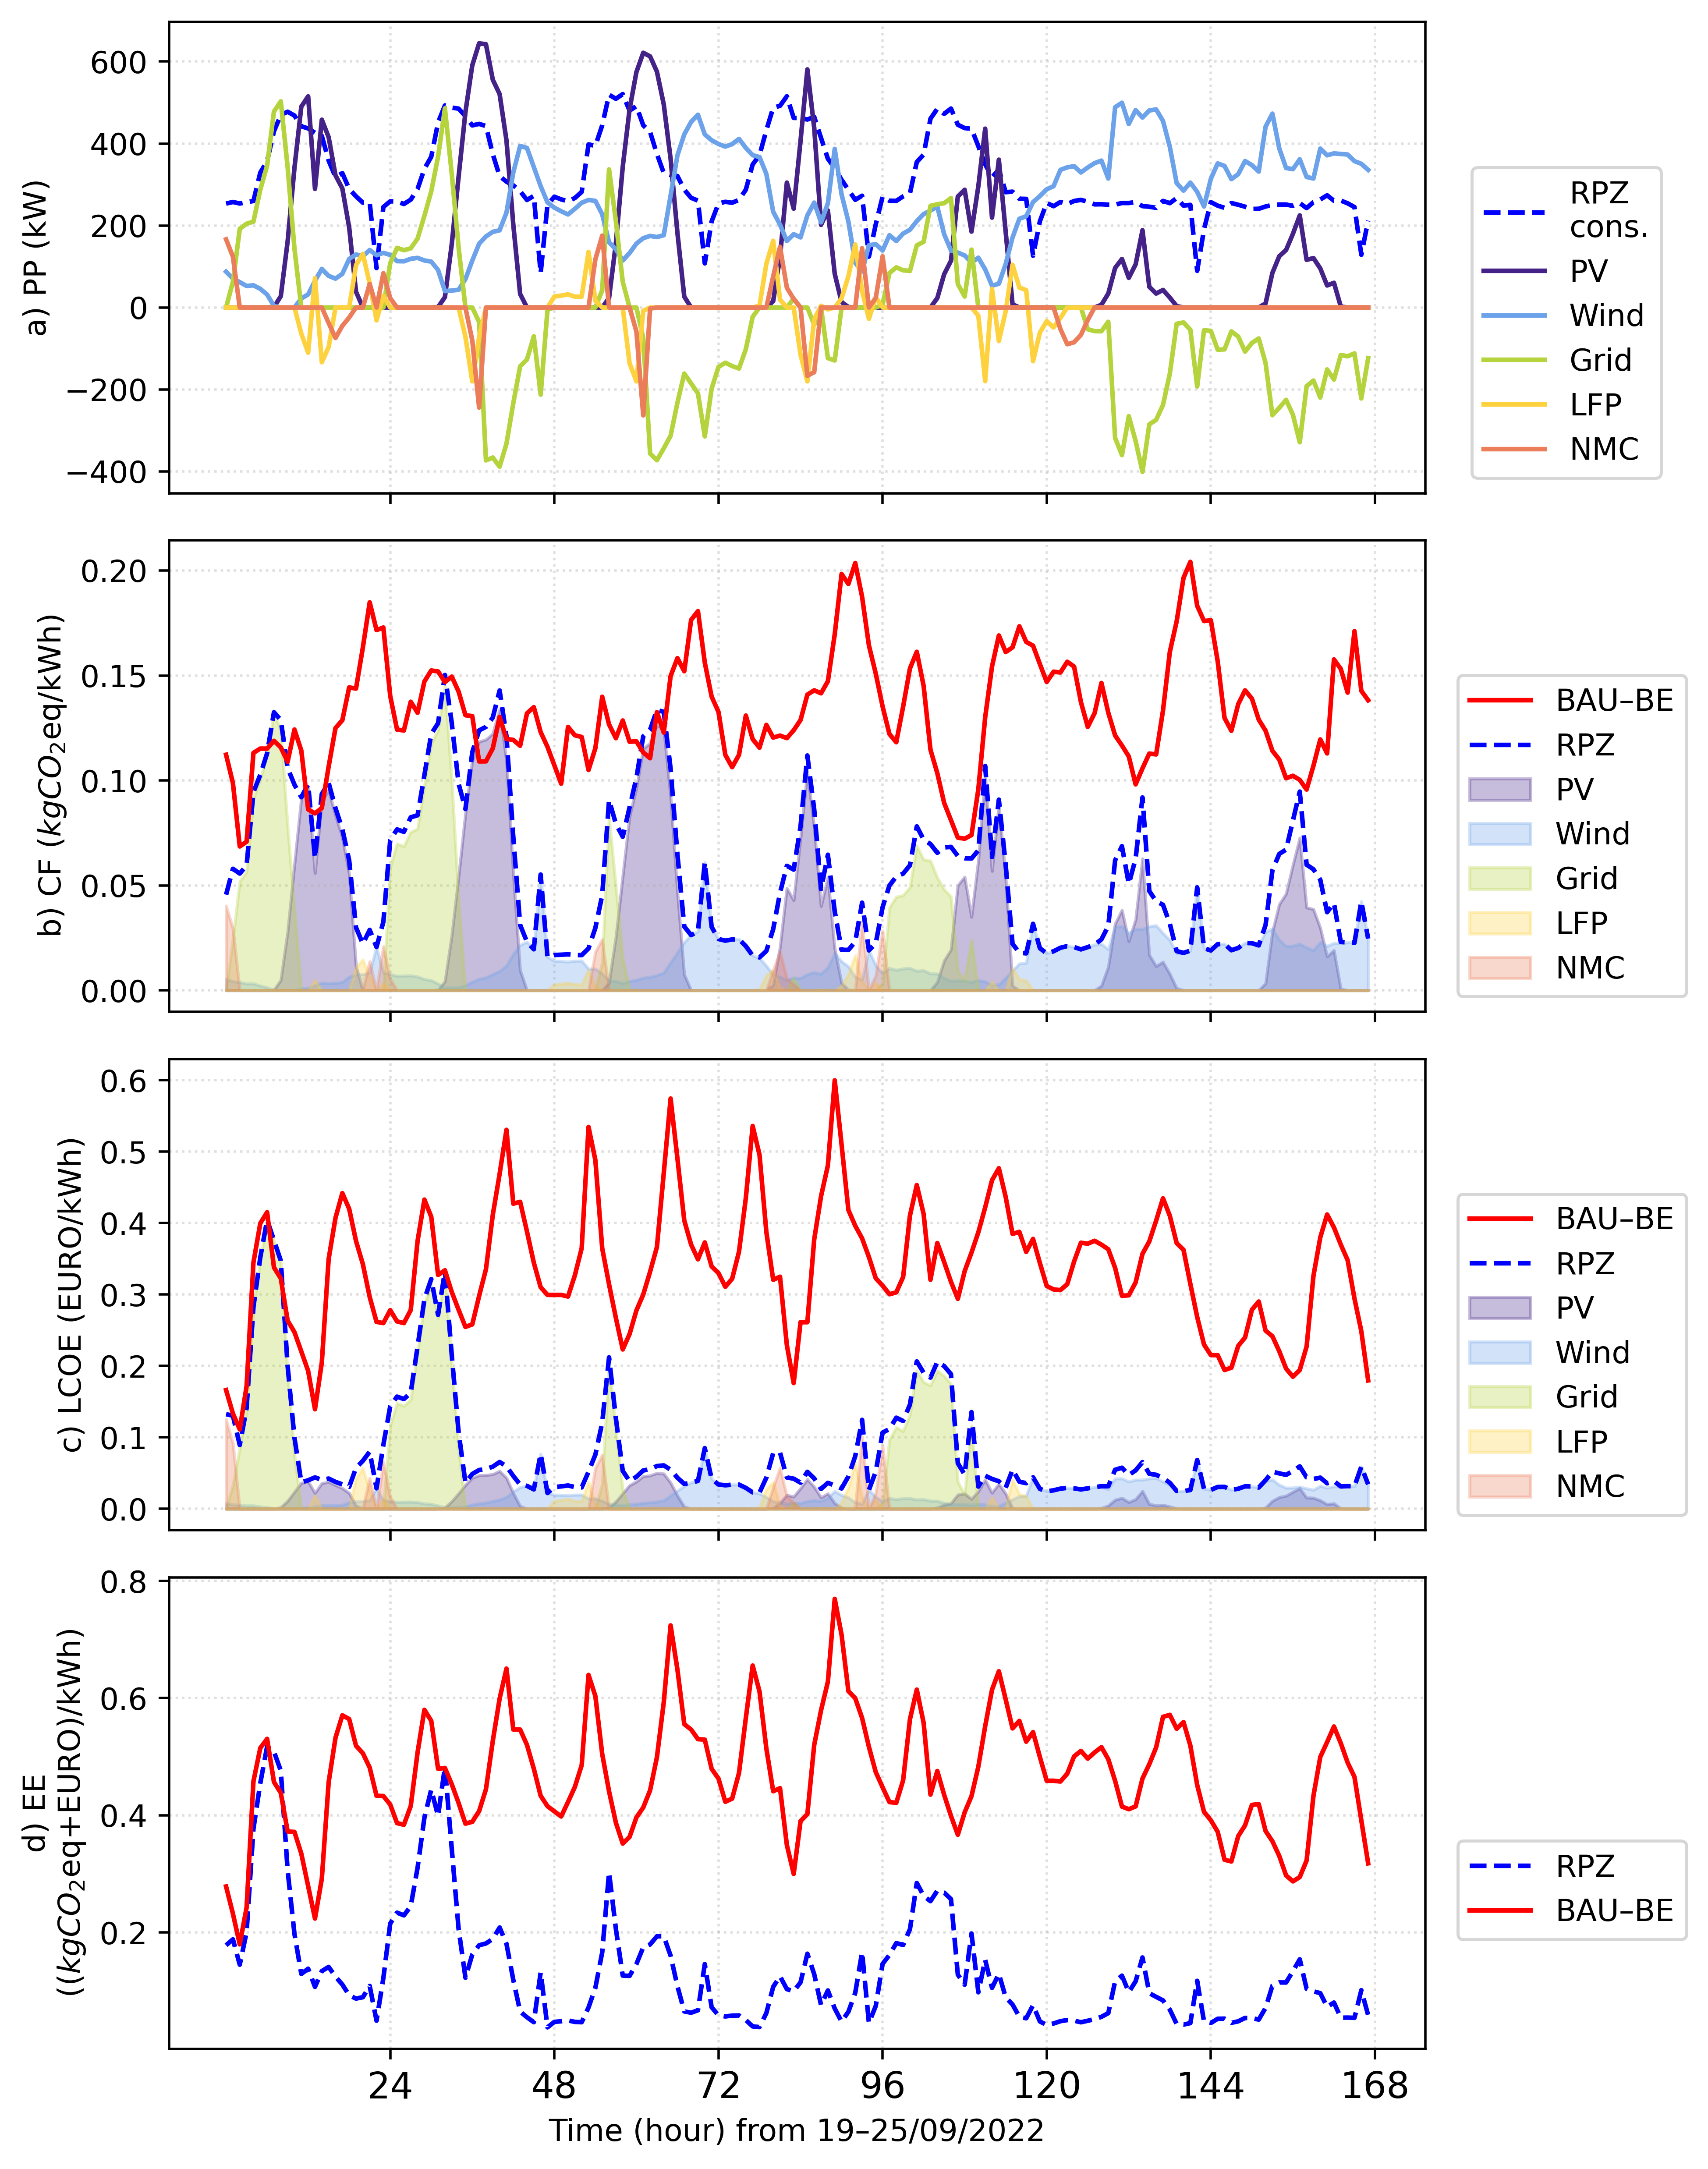

In [61]:
#Autumn
from pickle import TRUE

ser=pd.Series(range(168))

cc_week = pd.DataFrame(list(zip(h_cc_total[1728:1896], h_cc_total[4080:4248], h_cc_total[6264:6432], h_cc_total[8448:8616])),
               columns =['Spring', 'Summer', 'Autumn', 'Winter'])

lcoe_week = pd.DataFrame(list(zip(h_lcoe_total[1728:1896], h_lcoe_total[4080:4248], h_lcoe_total[6264:6432], h_lcoe_total[8448:8616])),
               columns =['Spring', 'Summer', 'Autumn', 'Winter'])

cc_autumn = pd.DataFrame(list(zip(hccpv_1[6264:6432], hccwind_1[6264:6432], hccgrid_1[6264:6432], hcclfp_1[6264:6432], hccnmc_1[6264:6432])),
               columns =['PV', 'Wind', 'Grid', 'LFP', 'NMC'])

lcoe_autumn = pd.DataFrame(list(zip(hlcoepv_1[6264:6432], hlcoewind_1[6264:6432], hlcoegrid_1[6264:6432], hlcoelfp_1[6264:6432], hlcoenmc_1[6264:6432])),
               columns =['PV', 'Wind', 'Grid', 'LFP', 'NMC'])

fig, axs = plt.subplots(4, 1, figsize=(8, 10), sharex='col', tight_layout=TRUE)
axs[0].plot([i*-1 for i in electric_consumer[6264:6432]], label='RPZ\ncons.', color='b', linestyle='--')
axs[0].plot(electric_solar[6264:6432], label='PV', color='#442288')
axs[0].plot(electric_wind[6264:6432], label='Wind', color='#6CA2EA')
axs[0].plot(electric_grid_tot[6264:6432], label='Grid', color='#B5D33D')
axs[0].plot(electric_lfp_tot[6264:6432], label='LFP', color='#FED23F')
axs[0].plot(electric_nmc_tot[6264:6432], label='NMC', color='#EB7D5B')
axs[0].set_ylabel('a) PP (kW)')
#axs[0].set_xlabel('Hourly timestep of one week')
axs[0].legend()
axs[0].legend(bbox_to_anchor=(1.2, 0.0), loc='lower right', ncol= 1, fontsize=10)
#axs[0].set_title('a) Power production of the RPZ in autumn')
axs[0].set_xticks([24, 48, 72, 96, 120, 144, 168]) 
axs[0].set_xticklabels([24, 48, 72, 96, 120, 144, 168], fontsize=12)
axs[0].grid(linestyle='dotted',alpha=0.4)

axs[1].plot(p[6264:6432], label='BAU–BE', color='r', zorder=8)
axs[1].plot((ser),(cc_week['Autumn']), label='RPZ', color='b', linestyle='--', zorder=7)
#axs[1].axhline(y=cc_total, color='y', linestyle='-.', label='Avg. energy\nsystem')
#axs[1].axhline(y=cc_grid, color='r', linestyle='-', label='Avg. BE\ngrid mix')
axs[1].fill_between((ser), (cc_autumn['PV']), color='#442288', alpha=0.3, zorder=1, label='PV')
axs[1].fill_between((ser), (cc_autumn['Wind']), color='#6CA2EA', alpha=0.3, zorder=2, label='Wind')
axs[1].fill_between((ser), (cc_autumn['Grid']), color='#B5D33D', alpha=0.3, zorder=3, label='Grid')
axs[1].fill_between((ser), (cc_autumn['LFP']), color='#FED23F', alpha=0.3, zorder=4, label='LFP')
axs[1].fill_between((ser), (cc_autumn['NMC']), color='#EB7D5B', alpha=0.3, zorder=5, label='NMC')
axs[1].set_ylabel('b) CF ($kgCO_2$eq/kWh)')
#axs[1].set_xlabel('Hourly timestep of one week')
axs[1].legend()
axs[1].legend(bbox_to_anchor=(1.22, 0.0), loc='lower right', ncol= 1, fontsize=10)
#axs[1].set_title('b) Carbon footprint of the RPZ in autumn')
axs[1].set_xticks([24, 48, 72, 96, 120, 144, 168]) 
axs[1].set_xticklabels([24, 48, 72, 96, 120, 144, 168], fontsize=12)
axs[1].grid(linestyle='dotted',alpha=0.4)

#print(lcoe_week)
axs[2].plot(q[6264:6432], label='BAU–BE', color='r', zorder=8)
axs[2].plot((ser),(lcoe_week['Autumn']), label='RPZ', color='b', linestyle='--', zorder=7)
#axs[2].axhline(y=avg_cost, color='y', linestyle='-.', label='Avg. energy\nsystem')
#axs[2].axhline(y=eur_kwh_grid, color='r', linestyle='-', label='Avg. BE\ngrid price')
axs[2].fill_between((ser), (lcoe_autumn['PV']), color='#442288', alpha=0.3, zorder=1, label='PV')
axs[2].fill_between((ser), (lcoe_autumn['Wind']), color='#6CA2EA', alpha=0.3, zorder=2, label='Wind')
axs[2].fill_between((ser), (lcoe_autumn['Grid']), color='#B5D33D', alpha=0.3, zorder=3, label='Grid')
axs[2].fill_between((ser), (lcoe_autumn['LFP']), color='#FED23F', alpha=0.3, zorder=4, label='LFP')
axs[2].fill_between((ser), (lcoe_autumn['NMC']), color='#EB7D5B', alpha=0.3, zorder=5, label='NMC')
axs[2].set_ylabel('c) LCOE (EURO/kWh)')
#axs[2].set_xlabel('Hourly timestep of one week')
axs[2].legend()
axs[2].legend(bbox_to_anchor=(1.22, 0.0), loc='lower right', ncol= 1, fontsize=10)
##axs[2].set_title('c) Levelized cost of electricity of the RPZ in autumn')
axs[2].set_xticks([24, 48, 72, 96, 120, 144, 168]) 
axs[2].set_xticklabels([24, 48, 72, 96, 120, 144, 168], fontsize=12)
axs[2].grid(linestyle='dotted',alpha=0.4)

#Stakeholder group 1: Energy cooperatives, real estate developer, local government
#Stakeholder group 2: Businesses, DSO
#axs[3].plot((ser),(eef3_sg1['ef_autumn']), label='SG1', linestyle="--", color='#000000', zorder=7)
#axs[3].plot((ser),(eef3_sg2['ef_autumn']), label='SG2', linestyle=":", color='#000000', zorder=7)
axs[3].plot((ser),(g['RPZ'][6264:6432]), label='RPZ', linestyle="--", color='b', zorder=7)
axs[3].plot((ser),(g['BAU–BE'][6264:6432]), label='BAU–BE', color='r', zorder=7)
axs[3].set_ylabel('d) EE\n(($kgCO_2$eq+EURO)/kWh)')
axs[3].set_xlabel('Time (hour) from 19–25/09/2022')
axs[3].legend()
axs[3].legend(bbox_to_anchor=(1.22, 0.2), loc='lower right', ncol= 1, fontsize=10)
#axs[3].set_title('d) Eco-efficiency of the RPZ in autumn')
axs[3].set_xticks([24, 48, 72, 96, 120, 144, 168]) 
axs[3].set_xticklabels([24, 48, 72, 96, 120, 144, 168], fontsize=12)
axs[3].grid(linestyle='dotted',alpha=0.4)

fig.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.06)
plt.show()
plt.rcParams["figure.dpi"] = 500

#alpha=0.3
#zorder=

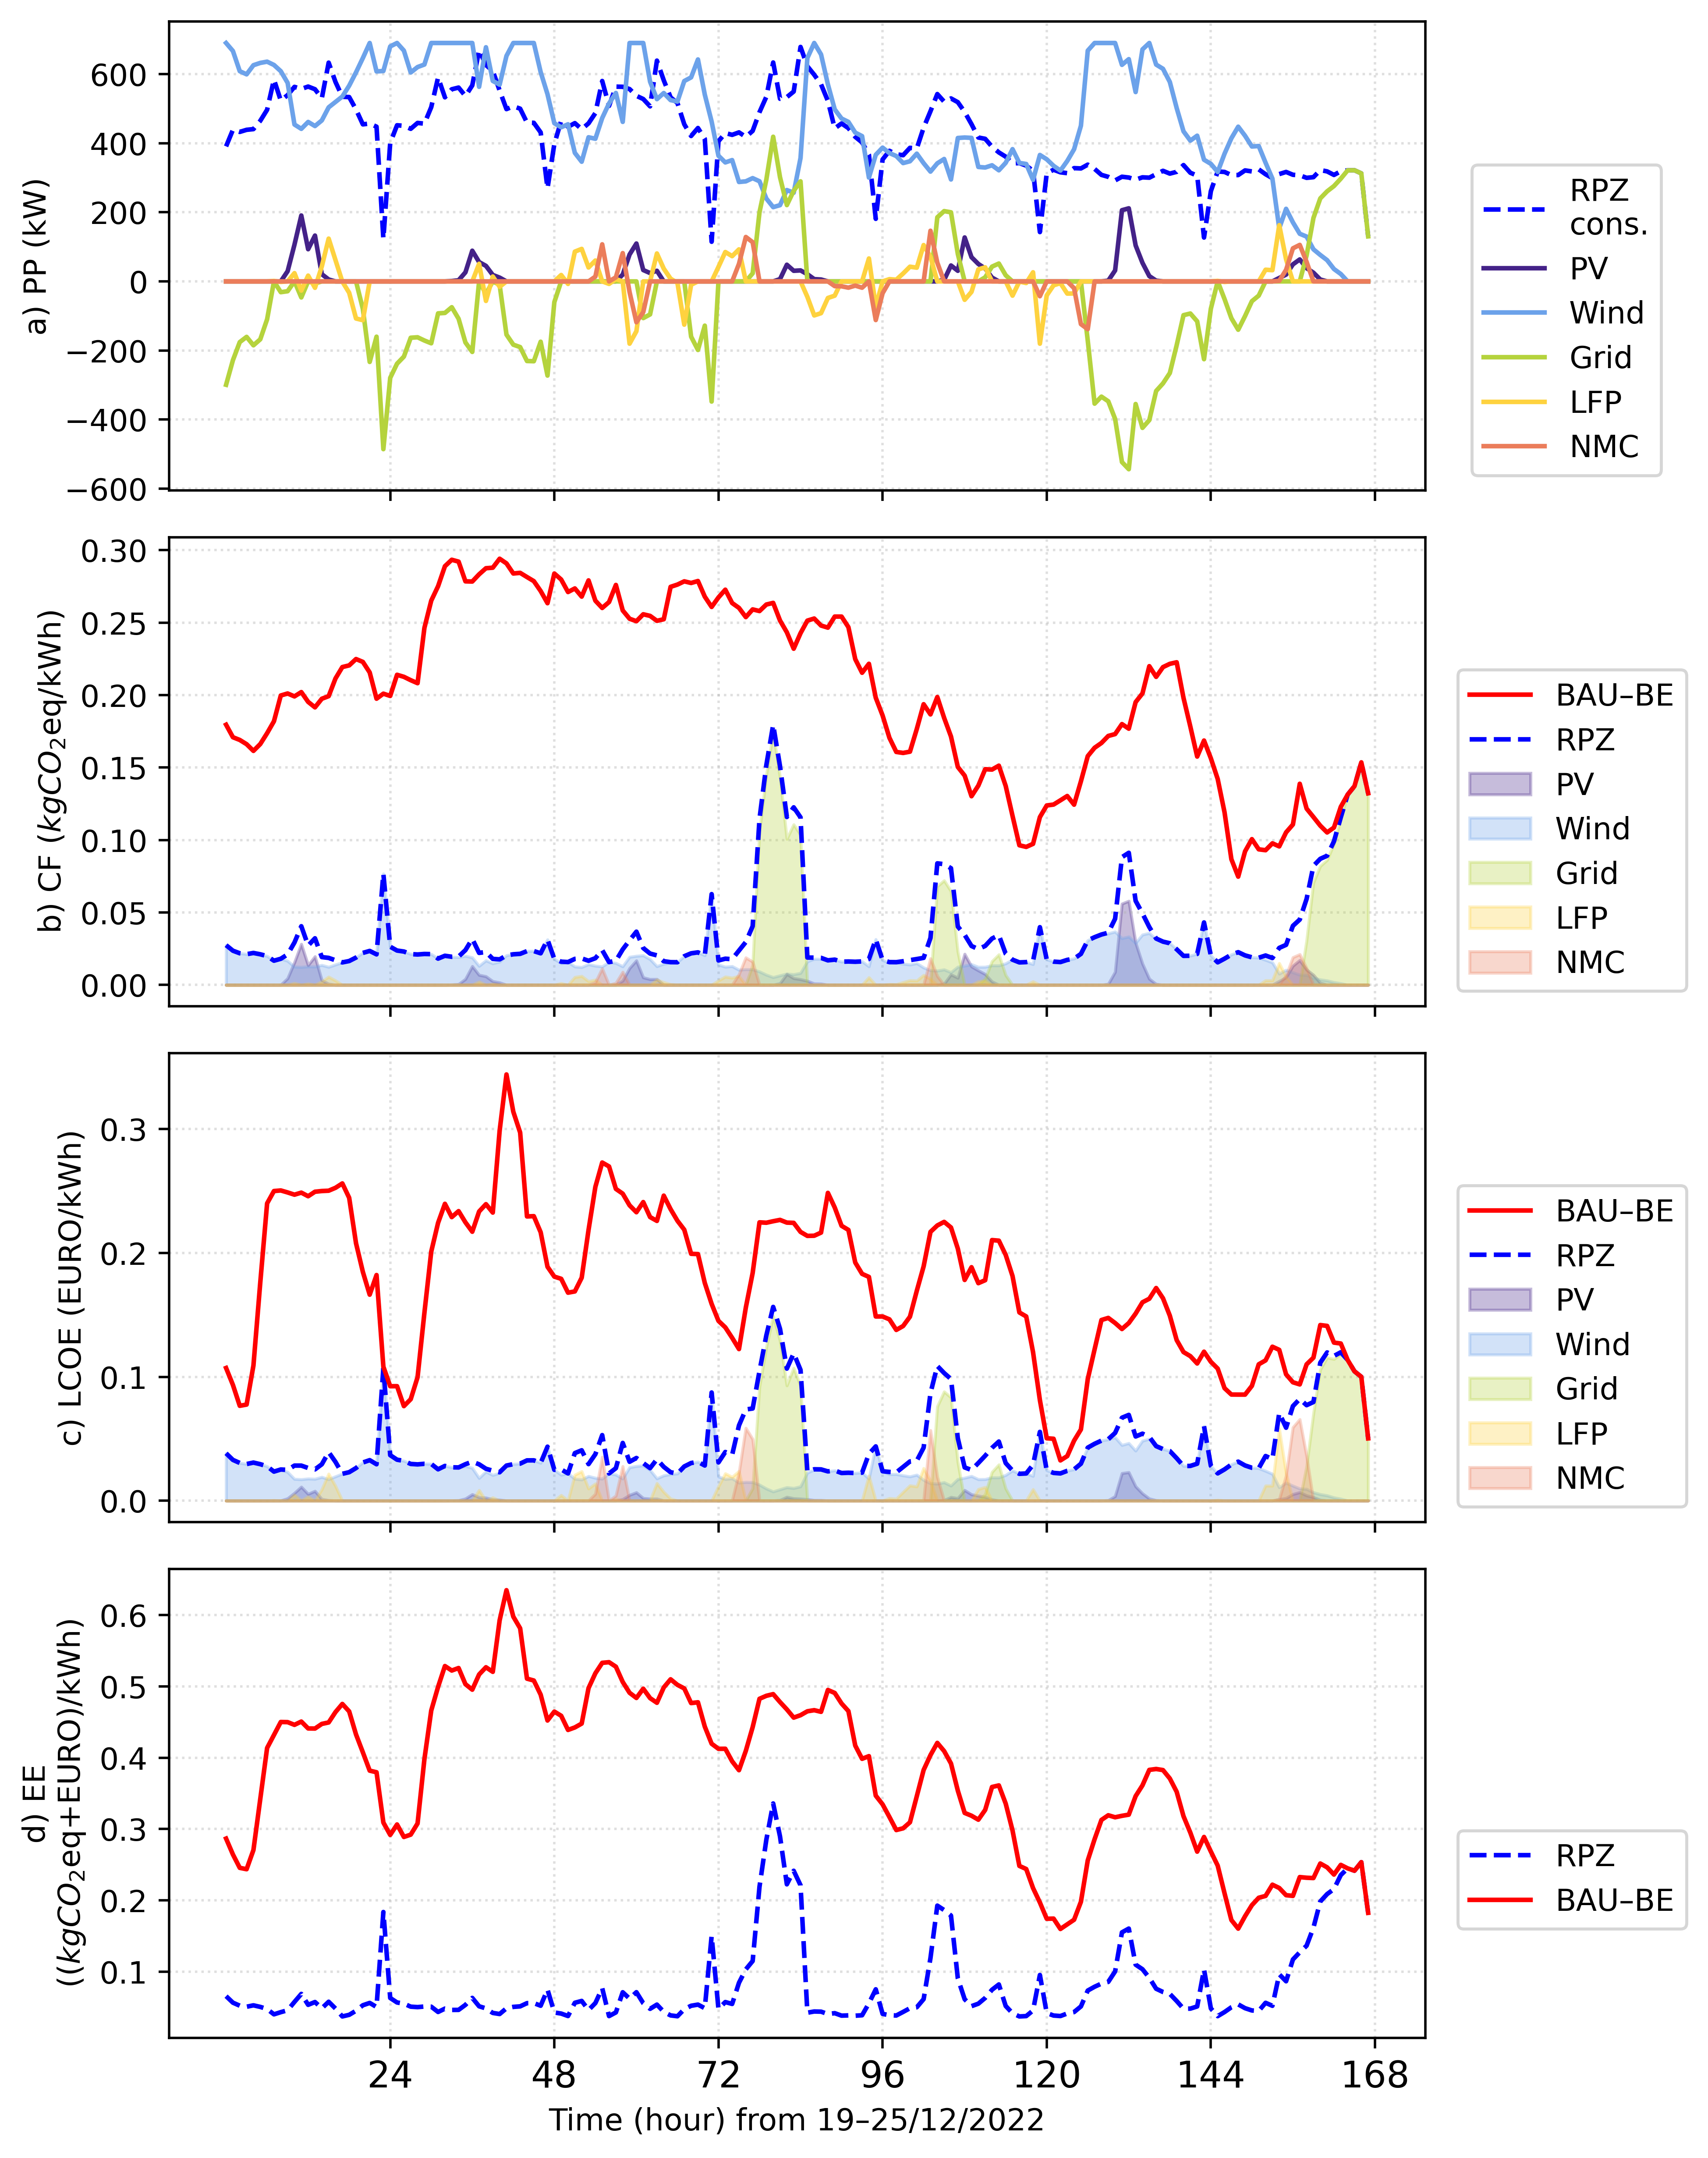

In [62]:
#Winter
from pickle import TRUE

ser=pd.Series(range(168))

cc_week = pd.DataFrame(list(zip(h_cc_total[1728:1896], h_cc_total[4080:4248], h_cc_total[6264:6432], h_cc_total[8448:8616])),
               columns =['Spring', 'Summer', 'Autumn', 'Winter'])

lcoe_week = pd.DataFrame(list(zip(h_lcoe_total[1728:1896], h_lcoe_total[4080:4248], h_lcoe_total[6264:6432], h_lcoe_total[8448:8616])),
               columns =['Spring', 'Summer', 'Autumn', 'Winter'])

cc_winter = pd.DataFrame(list(zip(hccpv_1[8448:8616], hccwind_1[8448:8616], hccgrid_1[8448:8616], hcclfp_1[8448:8616], hccnmc_1[8448:8616])),
               columns =['PV', 'Wind', 'Grid', 'LFP', 'NMC'])

lcoe_winter = pd.DataFrame(list(zip(hlcoepv_1[8448:8616], hlcoewind_1[8448:8616], hlcoegrid_1[8448:8616], hlcoelfp_1[8448:8616], hlcoenmc_1[8448:8616])),
               columns =['PV', 'Wind', 'Grid', 'LFP', 'NMC'])

fig, axs = plt.subplots(4, 1, figsize=(8, 10), sharex='col', tight_layout=TRUE)
axs[0].plot([i*-1 for i in electric_consumer[8448:8616]], label='RPZ\ncons.', color='b', linestyle='--')
axs[0].plot(electric_solar[8448:8616], label='PV', color='#442288')
axs[0].plot(electric_wind[8448:8616], label='Wind', color='#6CA2EA')
axs[0].plot(electric_grid_tot[8448:8616], label='Grid', color='#B5D33D')
axs[0].plot(electric_lfp_tot[8448:8616], label='LFP', color='#FED23F')
axs[0].plot(electric_nmc_tot[8448:8616], label='NMC', color='#EB7D5B')
axs[0].set_ylabel('a) PP (kW)')
#axs[0].set_xlabel('Hourly timestep of one week')
axs[0].legend()
axs[0].legend(bbox_to_anchor=(1.2, 0.0), loc='lower right', ncol= 1, fontsize=10)
#axs[0].set_title('a) Power production of the RPZ in winter')
axs[0].set_xticks([24, 48, 72, 96, 120, 144, 168]) 
axs[0].set_xticklabels([24, 48, 72, 96, 120, 144, 168], fontsize=12)
axs[0].grid(linestyle='dotted',alpha=0.4)

axs[1].plot(p[8448:8616], label='BAU–BE', color='r', zorder=8)
axs[1].plot((ser),(cc_week['Winter']), label='RPZ', color='b', linestyle='--', zorder=7)
#axs[1].axhline(y=cc_total, color='y', linestyle='-.', label='Avg. energy\nsystem')
#axs[1].axhline(y=cc_grid, color='r', linestyle='-', label='Avg. BE\ngrid mix')
axs[1].fill_between((ser), (cc_winter['PV']), color='#442288', alpha=0.3, zorder=1, label='PV')
axs[1].fill_between((ser), (cc_winter['Wind']), color='#6CA2EA', alpha=0.3, zorder=2, label='Wind')
axs[1].fill_between((ser), (cc_winter['Grid']), color='#B5D33D', alpha=0.3, zorder=3, label='Grid')
axs[1].fill_between((ser), (cc_winter['LFP']), color='#FED23F', alpha=0.3, zorder=4, label='LFP')
axs[1].fill_between((ser), (cc_winter['NMC']), color='#EB7D5B', alpha=0.3, zorder=5, label='NMC')
axs[1].set_ylabel('b) CF ($kgCO_2$eq/kWh)')
#axs[1].set_xlabel('Hourly timestep of one week')
axs[1].legend()
axs[1].legend(bbox_to_anchor=(1.22, 0.0), loc='lower right', ncol= 1, fontsize=10)
#axs[1].set_title('b) Carbon footprint of the RPZ in winter')
axs[1].set_xticks([24, 48, 72, 96, 120, 144, 168]) 
axs[1].set_xticklabels([24, 48, 72, 96, 120, 144, 168], fontsize=12)
axs[1].grid(linestyle='dotted',alpha=0.4)


#print(lcoe_week)
axs[2].plot(q[8448:8616], label='BAU–BE', color='r', linestyle='-', zorder=8)
axs[2].plot((ser),(lcoe_week['Winter']), label='RPZ', color='b', linestyle='--', zorder=7)
#axs[2].axhline(y=avg_cost, color='y', linestyle='-.', label='Avg. energy\nsystem')
#axs[2].axhline(y=eur_kwh_grid, color='r', linestyle='-', label='Avg. BE\ngrid price')
axs[2].fill_between((ser), (lcoe_winter['PV']), color='#442288', alpha=0.3, zorder=1, label='PV')
axs[2].fill_between((ser), (lcoe_winter['Wind']), color='#6CA2EA', alpha=0.3, zorder=2, label='Wind')
axs[2].fill_between((ser), (lcoe_winter['Grid']), color='#B5D33D', alpha=0.3, zorder=3, label='Grid')
axs[2].fill_between((ser), (lcoe_winter['LFP']), color='#FED23F', alpha=0.3, zorder=4, label='LFP')
axs[2].fill_between((ser), (lcoe_winter['NMC']), color='#EB7D5B', alpha=0.3, zorder=5, label='NMC')
axs[2].set_ylabel('c) LCOE (EURO/kWh)')
#axs[2].set_xlabel('Hourly timestep of one week')
axs[2].legend()
axs[2].legend(bbox_to_anchor=(1.22, 0.0), loc='lower right', ncol= 1, fontsize=10)
#axs[2].set_title('c) Levelized cost of electricity of the RPZ in winter')
axs[2].set_xticks([24, 48, 72, 96, 120, 144, 168]) 
axs[2].set_xticklabels([24, 48, 72, 96, 120, 144, 168], fontsize=12)
axs[2].grid(linestyle='dotted',alpha=0.4)

#Stakeholder group 1: Energy cooperatives, real estate developer, local government
#Stakeholder group 2: Businesses, DSO
#axs[3].plot((ser),(eef3_sg1['ef_winter']), label='SG1', linestyle="--", color='#000000', zorder=7)
#axs[3].plot((ser),(eef3_sg2['ef_winter']), label='SG2', linestyle=":", color='#000000', zorder=7)
axs[3].plot((ser),(g['RPZ'][8448:8616]), label='RPZ', linestyle="--", color='b', zorder=7)
axs[3].plot((ser),(g['BAU–BE'][8448:8616]), label='BAU–BE', color='r', zorder=7)
axs[3].set_ylabel('d) EE\n(($kgCO_2$eq+EURO)/kWh)')
axs[3].set_xlabel('Time (hour) from 19–25/12/2022')
axs[3].legend()
axs[3].legend(bbox_to_anchor=(1.22, 0.2), loc='lower right', ncol= 1, fontsize=10)
#axs[3].set_title('d) Eco-efficiency of the RPZ in winter')
axs[3].set_xticks([24, 48, 72, 96, 120, 144, 168]) 
axs[3].set_xticklabels([24, 48, 72, 96, 120, 144, 168], fontsize=12)
axs[3].grid(linestyle='dotted',alpha=0.4)

fig.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.06)
plt.show()
plt.rcParams["figure.dpi"] = 500

#alpha=0.3
#zorder=

# 6. Comparative framework

In the following, the code to calculate the eco-efficiency of a case study in Poland and Spain is presented. Additionally, a sensitivity analysis is included. Further details are provided in the manuscript.

  System    Annual    Spring    Summer    Autumn    Winter
0    RPZ  0.196828  0.145706  0.204672  0.134008  0.079311
1     BE  0.411795  0.411390  0.427294  0.467290  0.375441
2     BB  1.477336  1.428991  1.856090  1.595405  0.975182
3     PL  0.942212  0.915784  0.977194  0.983215  1.006783
4     VV  0.314024  0.255769  0.347382  0.323130  0.166706
5     ES  0.281801  0.232021  0.290261  0.299477  0.161918


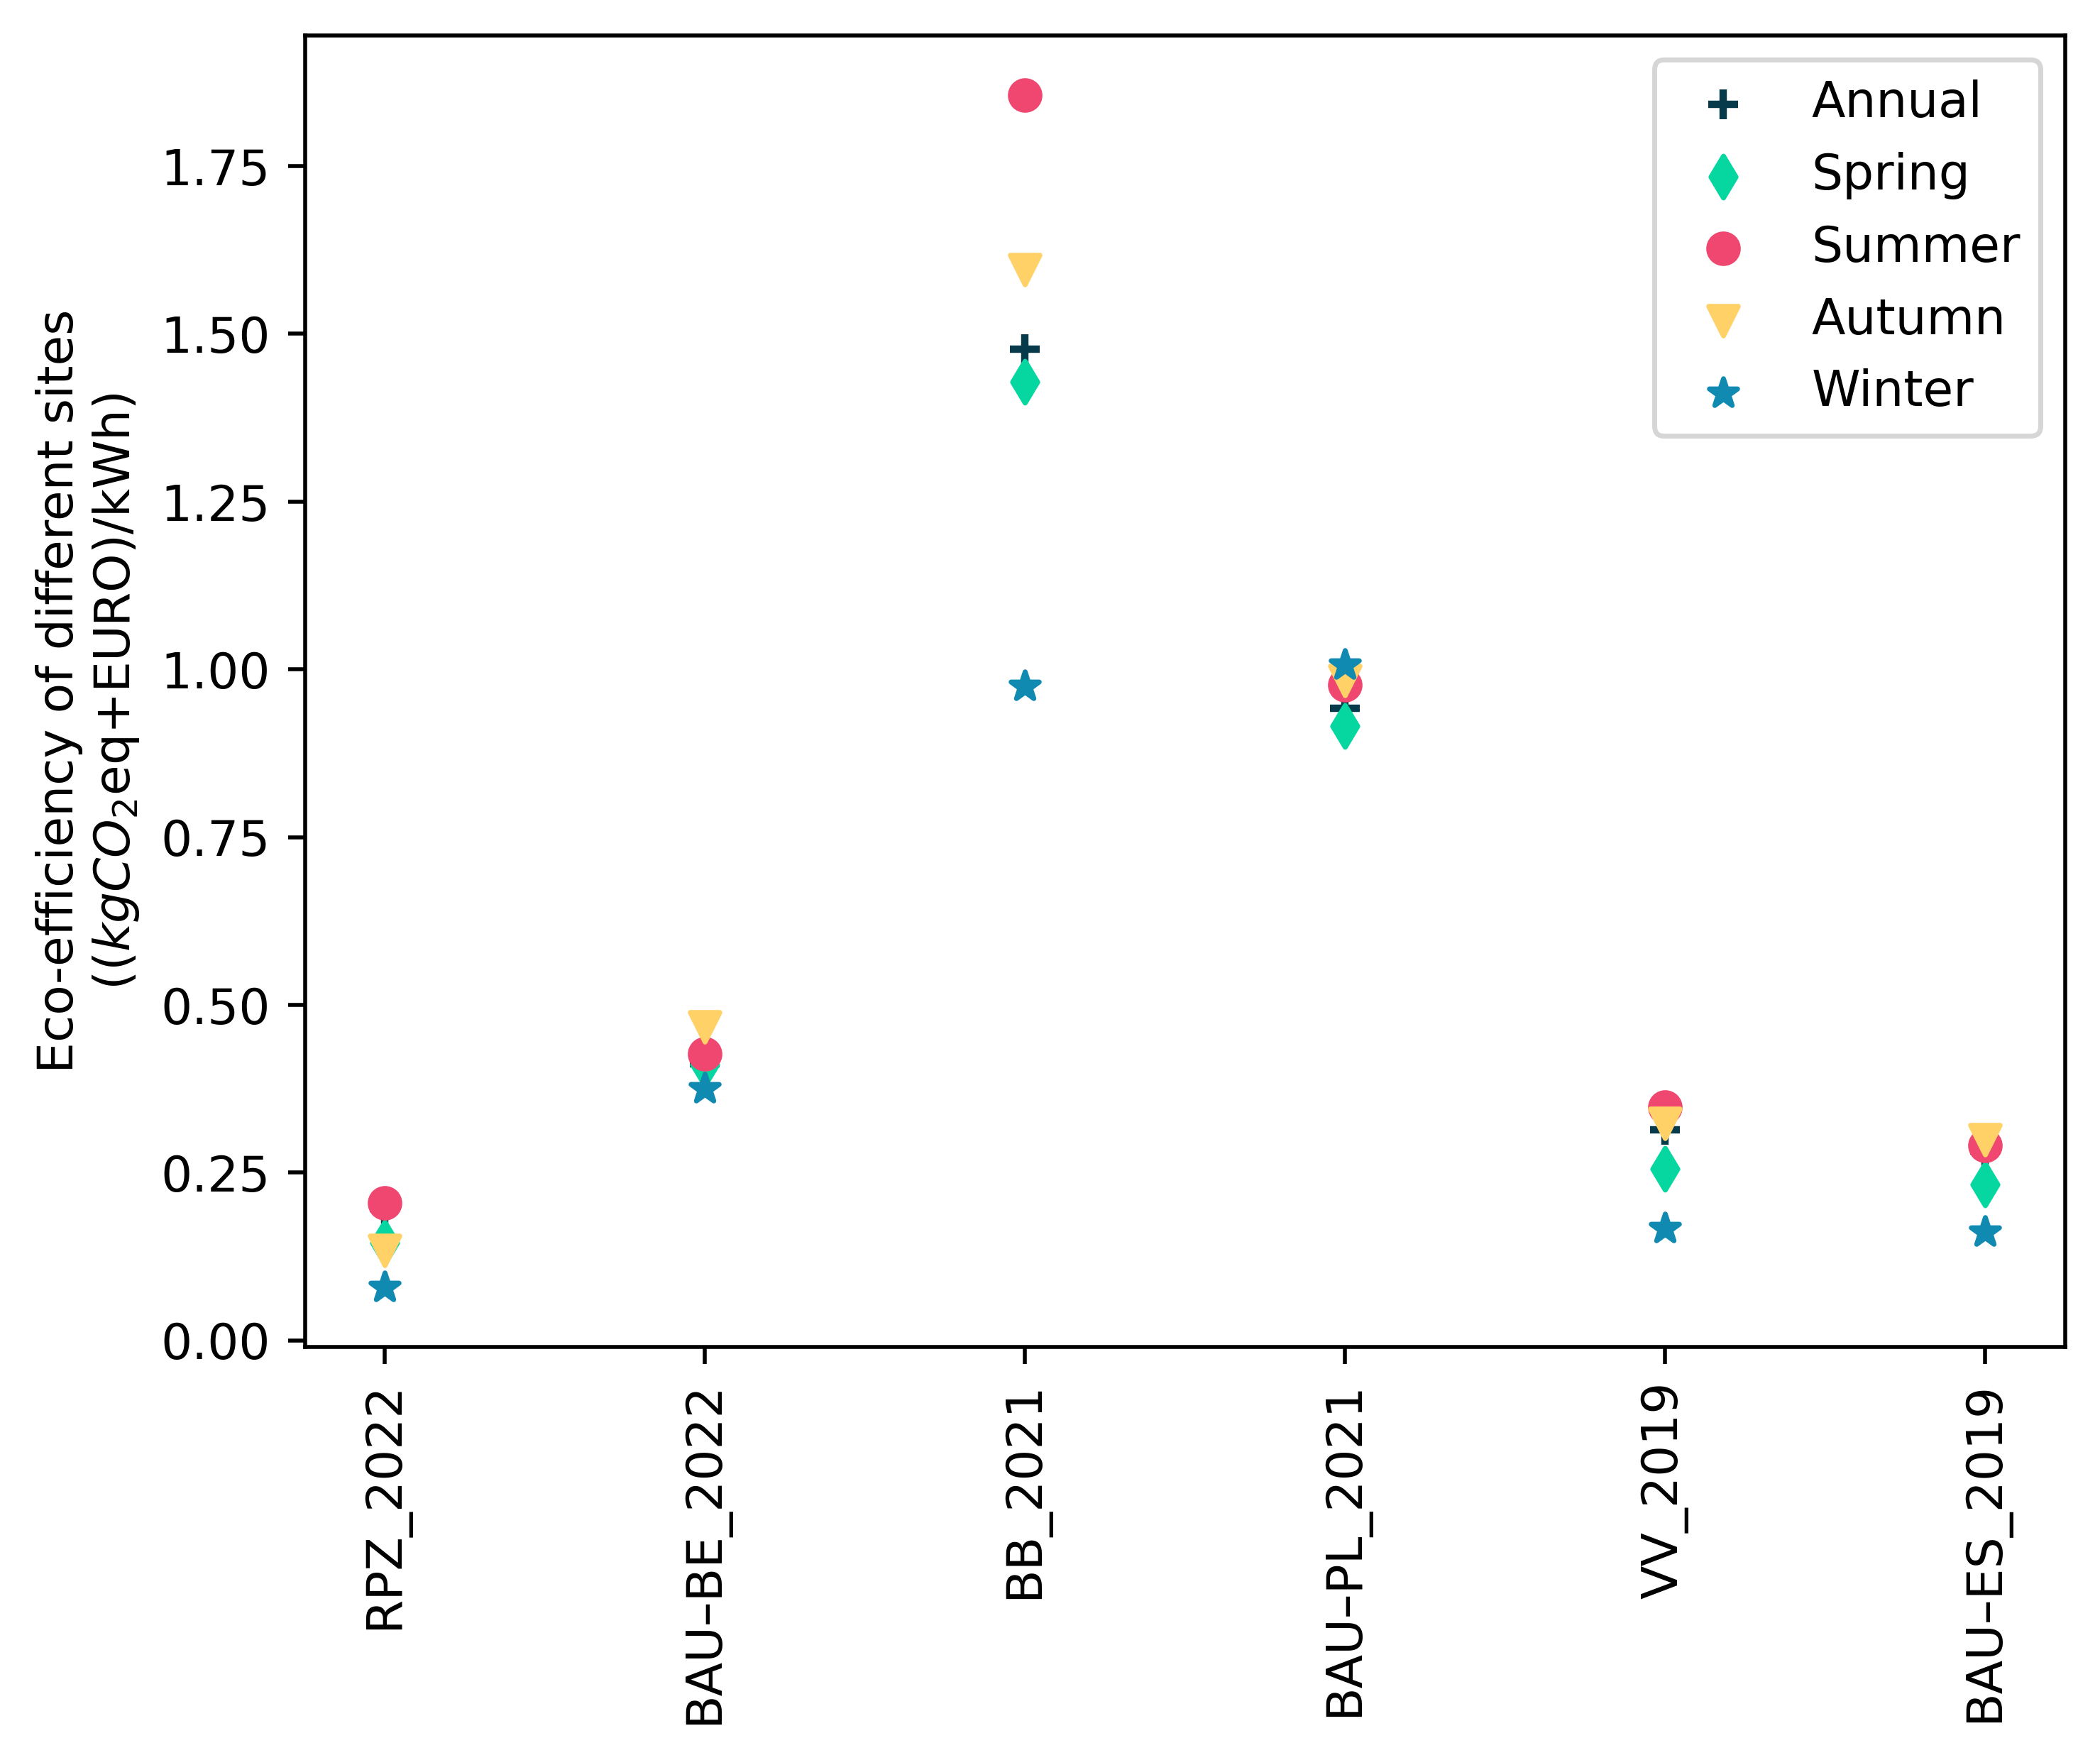

In [63]:
rpz_an = g['RPZ'].mean()
rpz_sp = g['RPZ'][1728:1896].mean()
rpz_su = g['RPZ'][4080:4248].mean()
rpz_au = g['RPZ'][6264:6432].mean()
rpz_wi = g['RPZ'][8448:8616].mean()

bau_be_an = g['BAU–BE'].mean()
bau_be_sp = g['BAU–BE'][1728:1896].mean()
bau_be_su = g['BAU–BE'][4080:4248].mean()
bau_be_au = g['BAU–BE'][6264:6432].mean()
bau_be_wi = g['BAU–BE'][8448:8616].mean()

BB = pd.read_csv('C:/Users/dhuber/OneDrive - Vrije Universiteit Brussel/10_Design_optimization_framework/MAMUeT/POL_Beli_Bertoka/ee_pl_2021.csv',encoding='cp1252')
bb_an = BB['BB'].mean()
bb_sp = BB['BB'][1752:1920].mean()
bb_su = BB['BB'][4104:4272].mean()
bb_au = BB['BB'][6288:6456].mean()
bb_wi = BB['BB'][8352:8520].mean()

bau_pl_an = BB['BAU–PL'].mean()
bau_pl_sp = BB['BAU–PL'][1752:1920].mean()
bau_pl_su = BB['BAU–PL'][4104:4272].mean()
bau_pl_au = BB['BAU–PL'][6288:6456].mean()
bau_pl_wi = BB['BAU–PL'][8352:8520].mean()

VV = pd.read_csv('C:/Users/dhuber/OneDrive - Vrije Universiteit Brussel/10_Design_optimization_framework/MAMUeT/Vega de Valcarce ESP/ee_es_2019.csv',encoding='cp1252')
vv_an = VV['VV'].mean()
vv_sp = VV['VV'][1752:1920].mean()
vv_su = VV['VV'][4104:4272].mean()
vv_au = VV['VV'][6288:6456].mean()
vv_wi = VV['VV'][8352:8520].mean()

bau_es_an = VV['BAU–ES'].mean()
bau_es_sp = VV['BAU–ES'][1752:1920].mean()
bau_es_su = VV['BAU–ES'][4104:4272].mean()
bau_es_au = VV['BAU–ES'][6288:6456].mean()
bau_es_wi = VV['BAU–ES'][8352:8520].mean()

s=pd.DataFrame()
s['System']=['RPZ', 'BE', 'BB', 'PL', 'VV', 'ES']
s['Annual']=[rpz_an, bau_be_an, bb_an, bau_pl_an, vv_an, bau_es_an]
s['Spring']=[rpz_sp, bau_be_sp, bb_sp, bau_pl_sp, vv_sp, bau_es_sp]
s['Summer']=[rpz_su, bau_be_su, bb_su, bau_pl_su, vv_su, bau_es_su]
s['Autumn']=[rpz_au, bau_be_au, bb_au, bau_pl_au, vv_au, bau_es_au]
s['Winter']=[rpz_wi, bau_be_wi, bb_wi, bau_pl_wi, vv_wi, bau_es_wi]

print(s)

sites = ['RPZ_2022', 'BAU–BE_2022', 'BB_2021', 'BAU–PL_2021', 'VV_2019', 'BAU–ES_2019']
plt.scatter(sites, s['Annual'], label='Annual', marker='+', color='#073b4c')
plt.scatter(sites, s['Spring'], label='Spring', marker='d', color='#06d6a0')
plt.scatter(sites, s['Summer'], label='Summer', marker='o', color='#ef476f')
plt.scatter(sites, s['Autumn'], label='Autumn', marker='v', color='#ffd166')
plt.scatter(sites, s['Winter'], label='Winter', marker='*', color='#118ab2')
plt.ylabel('Eco-efficiency of different sites\n(($kgCO_2$eq+EURO)/kWh)')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [64]:
s2 = {'Annual electricity':[1.767503, 1.937364, 2.082290, 2.136235, 2.479658, 2.541924, 2.781561, 3.314022, 3.397262, 3.659338, 3.698159, 3.922869, 3.953426, 3.971321, 3.995301, 4.538776, 4.600178, 4.710742, 4.880696, 4.940314],
        'se1':[0.12916219, 0.128018477, 0.127774936, 0.128020107, 0.132987289, 0.135399055, 0.140685666, 0.155832095, 0.158495772, 0.168630999, 0.170240941, 0.18214023, 0.184203878, 0.185183311, 0.186456367, 0.217703219, 0.220643647, 0.225776635, 0.233542414, 0.235621819],
        'ES lifetime':[13, 15, 16, 16, 17, 18, 18, 20, 23, 24, 25, 26, 27, 28, 33, 33, 33, 35, 36, 37],
        'se2':[0.1277330412, 0.1324820942, 0.1348403067, 0.1348403067, 0.1370530836, 0.1392975804, 0.1392975804, 0.1436427097, 0.1498703474, 0.1517371150, 0.1540430277, 0.1563600235, 0.1582930888, 0.1601043413, 0.1710357078, 0.1710357078, 0.1710357078, 0.1752265704, 0.1771242829, 0.1791799458],
        'Weighting SG1':[1, 8, 18, 20, 25, 33, 44, 44, 46, 49, 53, 57, 59, 65, 72, 75, 88, 89, 89, 96],
        'se3':[0.0822287260, 0.0832418136, 0.0827787656, 0.0830203803, 0.0826678218, 0.0817101182, 0.0804452350, 0.0804452350, 0.0801008760, 0.0795570701, 0.0791292085, 0.0785290913, 0.0782634048, 0.0771601492, 0.0759508469, 0.0752230443, 0.0723159666, 0.0720742886, 0.0720742886, 0.0710298262],
        'Weighting SG2':[1, 8, 18, 20, 25, 33, 44, 44, 46, 49, 53, 57, 59, 65, 72, 75, 88, 89, 89, 96],
        'se4':[0.0705560820, 0.0716542925, 0.0740660719, 0.0745169799, 0.0752230443, 0.0769009744, 0.0786714924, 0.0786714924, 0.0789105582, 0.0791784759, 0.0799156197, 0.0807284266, 0.0810849286, 0.0816677953, 0.0824690818, 0.0826678218, 0.0833170528, 0.0832649581, 0.0832649581, 0.0828607206],
        'Density LFP':[0.063, 0.073, 0.078, 0.08, 0.084, 0.088, 0.103, 0.107, 0.116, 0.124, 0.129, 0.148, 0.161, 0.161, 0.162, 0.167, 0.172, 0.174, 0.181, 0.186],
        'se5':[0.1544458282, 0.1542703931, 0.1542141437, 0.1542141437, 0.1542094663, 0.1542094663, 0.1541058550, 0.1540430277, 0.1540430277, 0.1540430277, 0.1540371568, 0.1539909706, 0.1539891063, 0.1539891063, 0.1539879477, 0.1539852436, 0.1539852436, 0.1539852436, 0.1539826590, 0.1539596402],
        'Density NMC':[0.072, 0.08, 0.081, 0.082, 0.093, 0.114, 0.118, 0.127, 0.132, 0.137, 0.143, 0.146, 0.153, 0.161, 0.165, 0.177, 0.177, 0.195, 0.2, 0.212],
        'se6':[0.1560062172, 0.1558980707, 0.1558025472, 0.1556910899, 0.1551238134, 0.1543116262, 0.1542703931, 0.1542094663, 0.1541977756, 0.1541342325, 0.1540430277, 0.1539909706, 0.1538409928, 0.1536963268, 0.1536003928, 0.1535214152, 0.1535214152, 0.1533528962, 0.1533507676, 0.1533507676],
        'CF PV':[0.047222, 0.048472, 0.058364, 0.062446, 0.068601, 0.080421, 0.082176, 0.082328, 0.087678, 0.093271, 0.099782, 0.100622, 0.102800, 0.104701, 0.105108, 0.112749, 0.114662, 0.119937, 0.120678, 0.120904],
        'se7':[0.1320726304, 0.1328186200, 0.1395118471, 0.1423290685, 0.1455399004, 0.1529233320, 0.1539252265, 0.1540509935, 0.1573891751, 0.1605266583, 0.1640048771, 0.1646480370, 0.1661939121, 0.1674796150, 0.1676608347, 0.1724954823, 0.1734785870, 0.1767472188, 0.1771804200, 0.1772712683],
        'CF Wind':[0.008185868, 0.009092256, 0.01224123, 0.012445222, 0.013390342, 0.013630728, 0.013890445, 0.014410965, 0.014801199, 0.015218179, 0.015648104, 0.015658881, 0.015710945, 0.016135016, 0.017934712, 0.018924819, 0.019854196, 0.020249072, 0.020434959, 0.022378115],
        'se8':[0.1503932529, 0.1510195844, 0.1522924424, 0.1523599479, 0.1528588224, 0.1529935228, 0.1531170841, 0.1533334847, 0.1536283045, 0.1537765451, 0.1541043464, 0.1541180366, 0.1541652614, 0.1543550695, 0.1553001942, 0.1558462418, 0.1563989229, 0.1566048598, 0.1567107455, 0.1578447626],
        'CF LFP':[0.014644796, 0.015295888, 0.015853847, 0.01935849, 0.019672193, 0.019958772, 0.022082574, 0.023730798, 0.023812346, 0.02740115, 0.027633936, 0.029430124, 0.029646461, 0.031084248, 0.03384649, 0.035916992, 0.035921017, 0.038703943, 0.040815571, 0.04261278],
        'se9':[0.1538562148, 0.1538574702, 0.1538574702, 0.1539612820, 0.1539806470, 0.1539852436, 0.1539886133, 0.1539909706, 0.1539909706, 0.1540351912, 0.1540371647, 0.1540430277, 0.1540430277, 0.1540430277, 0.1541058550, 0.1541058550, 0.1541058550, 0.1541977756, 0.1542094663, 0.1542094663],
        'CF NMC':[0.034522412, 0.034734143, 0.040342176, 0.041790232, 0.044933252, 0.046424412, 0.051465514, 0.051741582, 0.05275668, 0.05677697, 0.059625518, 0.059884927, 0.06263628, 0.066221598, 0.066398621, 0.067075645, 0.079774463, 0.085930966, 0.090997379, 0.091043522],
        'se10':[0.1530915819, 0.1530915819, 0.1533507676, 0.1533507676, 0.1533507676, 0.1534080864, 0.1535481765, 0.1535481765, 0.1535712400, 0.1538409928, 0.1539909706, 0.1539909706, 0.1541058550, 0.1541688121, 0.1541977756, 0.1542094663, 0.1544868273, 0.1547794878, 0.1551238134, 0.1551238134],
        'CAPEX PV':[503, 506, 512, 522, 558, 625, 659, 710, 772, 888, 958, 1045, 1051, 1092, 1175, 1178, 1180, 1261, 1401, 1485],
        'se11':[0.1441564280, 0.1442684061, 0.1444122727, 0.1445697580, 0.1451130849, 0.1465931740, 0.1475349962, 0.1484939958, 0.1495849701, .1517425681, 0.1531203694, 0.1550231624, 0.1551989770, 0.1559952883, 0.1575532354, 0.1576096782, 0.1576465646, 0.1588767041, 0.1614759165, 0.1630189007],
        'CAPEX Wind':[554, 562, 656, 732, 783, 809, 842, 867, 1022, 1066, 1097, 1134, 1140, 1163, 1230, 1351, 1363, 1443, 1563, 1563],
        'se12':[0.1476107094, 0.1476290585, 0.1484031616, 0.1490138956, 0.1492125323, 0.1493459580, 0.1495982246, 0.1497563561, 0.1509935161, 0.1512105499, 0.1514392811, 0.1515691791, 0.1515870504, 0.1517105516, 0.1522794816, 0.1531741499, 0.1532442542, 0.1538510292, 0.1549791962, 0.1549791962],
        'CAPEX LFP':[221, 237, 240, 268, 283, 322, 347, 362, 373, 384, 392, 405, 432, 531, 534, 556, 583, 603, 614, 637],
        'se13':[0.153350768, 0.153371939, 0.153371939, 0.153490116, 0.153571240, 0.153639778, 0.153747571, 0.153793526, 0.153828875, 0.153857470, .153891567, 0.153985244, 0.154042484, 0.154311626, 0.154318740, 0.154445828, 0.154486827, 0.154679729, 0.154735512, 0.154987762],
        'CAPEX NMC':[232, 250, 292, 337, 350, 361, 389, 405, 454, 462, 477, 480, 486, 503, 580, 595, 598, 654, 658, 663],
        'se14':[0.150644244, 0.151005831, 0.151450018, 0.151900951, 0.152285497, 0.152733729, 0.153243212, 0.153350768, 0.154168812, 0.154209466, 0.154270393, 0.154311626, 0.154486827, 0.154886525, 0.156006217, 0.156188898, 0.156301357, 0.156972926, 0.157112291, 0.157271639]
}
sen2 =pd.DataFrame(data=s2)

In [65]:
#1 = 'Annual electricity'
x1 = np.array([0.12916219, 0.128018477, 0.127774936, 0.128020107, 0.132987289, 0.135399055, 0.140685666, 0.155832095, 0.158495772, 0.168630999, 0.170240941, 0.18214023, 0.184203878, 0.185183311, 0.186456367, 0.217703219, 0.220643647, 0.225776635, 0.233542414, 0.235621819])
y1 = np.array([1.767503, 1.937364, 2.082290, 2.136235, 2.479658, 2.541924, 2.781561, 3.314022, 3.397262, 3.659338, 3.698159, 3.922869, 3.953426, 3.971321, 3.995301, 4.538776, 4.600178, 4.710742, 4.880696, 4.940314])

slope, intercept, r, p, std_err = stats.linregress(x1, y1)

def myfunc(x1):
  return slope * x1 + intercept

mymodel1 = list(map(myfunc, x1))
sen2['r1'] = mymodel1

#####################################################################

#2 = 'ES lifetime'
x2 = np.array([0.1277330412, 0.1324820942, 0.1348403067, 0.1348403067, 0.1370530836, 0.1392975804, 0.1392975804, 0.1436427097, 0.1498703474, 0.1517371150, 0.1540430277, 0.1563600235, 0.1582930888, 0.1601043413, 0.1710357078, 0.1710357078, 0.1710357078, 0.1752265704, 0.1771242829, 0.1791799458])
y2 = np.array([13, 15, 16, 16, 17, 18, 18, 20, 23, 24, 25, 26, 27, 28, 33, 33, 33, 35, 36, 37])

slope, intercept, r, p, std_err = stats.linregress(x2, y2)

def myfunc(x2):
  return slope * x2 + intercept

mymodel2 = list(map(myfunc, x2))
sen2['r2'] = mymodel2

#####################################################################

#3 = 'Weighting SG1'
x3 = np.array([0.0822287260, 0.0832418136, 0.0827787656, 0.0830203803, 0.0826678218, 0.0817101182, 0.0804452350, 0.0804452350, 0.0801008760, 0.0795570701, 0.0791292085, 0.0785290913, 0.0782634048, 0.0771601492, 0.0759508469, 0.0752230443, 0.0723159666, 0.0720742886, 0.0720742886, 0.0710298262])
y3 = np.array([1, 8, 18, 20, 25, 33, 44, 44, 46, 49, 53, 57, 59, 65, 72, 75, 88, 89, 89, 96])

slope, intercept, r, p, std_err = stats.linregress(x3, y3)

def myfunc(x3):
  return slope * x3 + intercept

mymodel3 = list(map(myfunc, x3))
sen2['r3'] = mymodel3

#####################################################################

#4 = 'Weighting SG2'
x4 = np.array([0.0705560820, 0.0716542925, 0.0740660719, 0.0745169799, 0.0752230443, 0.0769009744, 0.0786714924, 0.0786714924, 0.0789105582, 0.0791784759, 0.0799156197, 0.0807284266, 0.0810849286, 0.0816677953, 0.0824690818, 0.0826678218, 0.0833170528, 0.0832649581, 0.0832649581, 0.0828607206])
y4 = np.array([1, 8, 18, 20, 25, 33, 44, 44, 46, 49, 53, 57, 59, 65, 72, 75, 88, 89, 89, 96])

slope, intercept, r, p, std_err = stats.linregress(x4, y4)

def myfunc(x4):
  return slope * x4 + intercept

mymodel4 = list(map(myfunc, x4))
sen2['r4'] = mymodel4

#####################################################################

#5 = 'Density LFP'
x5 = np.array([0.1544458282, 0.1542703931, 0.1542141437, 0.1542141437, 0.1542094663, 0.1542094663, 0.1541058550, 0.1540430277, 0.1540430277, 0.1540430277, 0.1540371568, 0.1539909706, 0.1539891063, 0.1539891063, 0.1539879477, 0.1539852436, 0.1539852436, 0.1539852436, 0.1539826590, 0.1539596402])
y5 = np.array([0.063, 0.073, 0.078, 0.08, 0.084, 0.088, 0.103, 0.107, 0.116, 0.124, 0.129, 0.148, 0.161, 0.161, 0.162, 0.167, 0.172, 0.174, 0.181, 0.186])
        
slope, intercept, r, p, std_err = stats.linregress(x5, y5)

def myfunc(x5):
  return slope * x5 + intercept

mymodel5 = list(map(myfunc, x5))
sen2['r5'] = mymodel5

#####################################################################

#6 = 'Density NMC'
x6 = np.array([0.1560062172, 0.1558980707, 0.1558025472, 0.1556910899, 0.1551238134, 0.1543116262, 0.1542703931, 0.1542094663, 0.1541977756, 0.1541342325, 0.1540430277, 0.1539909706, 0.1538409928, 0.1536963268, 0.1536003928, 0.1535214152, 0.1535214152, 0.1533528962, 0.1533507676, 0.1533507676])
y6 = np.array([0.072, 0.08, 0.081, 0.082, 0.093, 0.114, 0.118, 0.127, 0.132, 0.137, 0.143, 0.146, 0.153, 0.161, 0.165, 0.177, 0.177, 0.195, 0.2, 0.212])
        
slope, intercept, r, p, std_err = stats.linregress(x6, y6)

def myfunc(x6):
  return slope * x6 + intercept

mymodel6 = list(map(myfunc, x6))
sen2['r6'] = mymodel6

#####################################################################

#7 = 'CF PV'
x7 = np.array([0.1320726304, 0.1328186200, 0.1395118471, 0.1423290685, 0.1455399004, 0.1529233320, 0.1539252265, 0.1540509935, 0.1573891751, 0.1605266583, 0.1640048771, 0.1646480370, 0.1661939121, 0.1674796150, 0.1676608347, 0.1724954823, 0.1734785870, 0.1767472188, 0.1771804200, 0.1772712683])
y7 = np.array([0.047222, 0.048472, 0.058364, 0.062446, 0.068601, 0.080421, 0.082176, 0.082328, 0.087678, 0.093271, 0.099782, 0.100622, 0.102800, 0.104701, 0.105108, 0.112749, 0.114662, 0.119937, 0.120678, 0.120904])

slope, intercept, r, p, std_err = stats.linregress(x7, y7)

def myfunc(x7):
  return slope * x7 + intercept

mymodel7 = list(map(myfunc, x7))
sen2['r7'] = mymodel7

#####################################################################

#8 = 'CF Wind'
x8 = np.array([0.1503932529, 0.1510195844, 0.1522924424, 0.1523599479, 0.1528588224, 0.1529935228, 0.1531170841, 0.1533334847, 0.1536283045, 0.1537765451, 0.1541043464, 0.1541180366, 0.1541652614, 0.1543550695, 0.1553001942, 0.1558462418, 0.1563989229, 0.1566048598, 0.1567107455, 0.1578447626],)
y8 = np.array([0.008185868, 0.009092256, 0.01224123, 0.012445222, 0.013390342, 0.013630728, 0.013890445, 0.014410965, 0.014801199, 0.015218179, 0.015648104, 0.015658881, 0.015710945, 0.016135016, 0.017934712, 0.018924819, 0.019854196, 0.020249072, 0.020434959, 0.022378115])

slope, intercept, r, p, std_err = stats.linregress(x8, y8)

def myfunc(x8):
  return slope * x8 + intercept

mymodel8 = list(map(myfunc, x8))
sen2['r8'] = mymodel8

#####################################################################

#9 = 'CF LFP'
x9 = np.array([0.1538562148, 0.1538574702, 0.1538574702, 0.1539612820, 0.1539806470, 0.1539852436, 0.1539886133, 0.1539909706, 0.1539909706, 0.1540351912, 0.1540371647, 0.1540430277, 0.1540430277, 0.1540430277, 0.1541058550, 0.1541058550, 0.1541058550, 0.1541977756, 0.1542094663, 0.1542094663])
y9 = np.array([0.014644796, 0.015295888, 0.015853847, 0.01935849, 0.019672193, 0.019958772, 0.022082574, 0.023730798, 0.023812346, 0.02740115, 0.027633936, 0.029430124, 0.029646461, 0.031084248, 0.03384649, 0.035916992, 0.035921017, 0.038703943, 0.040815571, 0.04261278])

slope, intercept, r, p, std_err = stats.linregress(x9, y9)

def myfunc(x9):
  return slope * x9 + intercept

mymodel9 = list(map(myfunc, x9))
sen2['r9'] = mymodel9

#####################################################################

#10= 'CF NMC'
x10 = np.array([0.1530915819, 0.1530915819, 0.1533507676, 0.1533507676, 0.1533507676, 0.1534080864, 0.1535481765, 0.1535481765, 0.1535712400, 0.1538409928, 0.1539909706, 0.1539909706, 0.1541058550, 0.1541688121, 0.1541977756, 0.1542094663, 0.1544868273, 0.1547794878, 0.1551238134, 0.1551238134])
y10 = np.array([0.034522412, 0.034734143, 0.040342176, 0.041790232, 0.044933252, 0.046424412, 0.051465514, 0.051741582, 0.05275668, 0.05677697, 0.059625518, 0.059884927, 0.06263628, 0.066221598, 0.066398621, 0.067075645, 0.079774463, 0.085930966, 0.090997379, 0.091043522])
        
slope, intercept, r, p, std_err = stats.linregress(x10, y10)

def myfunc(x10):
  return slope * x10 + intercept

mymodel10 = list(map(myfunc, x10))
sen2['r10'] = mymodel10

#####################################################################

#11 = 'CAPEX PV'
x11 = np.array([0.1441564280, 0.1442684061, 0.1444122727, 0.1445697580, 0.1451130849, 0.1465931740, 0.1475349962, 0.1484939958, 0.1495849701, .1517425681, 0.1531203694, 0.1550231624, 0.1551989770, 0.1559952883, 0.1575532354, 0.1576096782, 0.1576465646, 0.1588767041, 0.1614759165, 0.1630189007])
y11 = np.array([503, 506, 512, 522, 558, 625, 659, 710, 772, 888, 958, 1045, 1051, 1092, 1175, 1178, 1180, 1261, 1401, 1485])

slope, intercept, r, p, std_err = stats.linregress(x11, y11)

def myfunc(x11):
  return slope * x11 + intercept

mymodel11 = list(map(myfunc, x11))
sen2['r11'] = mymodel11

#####################################################################

#12 = 'CAPEX Wind'
x12 = np.array([0.1476107094, 0.1476290585, 0.1484031616, 0.1490138956, 0.1492125323, 0.1493459580, 0.1495982246, 0.1497563561, 0.1509935161, 0.1512105499, 0.1514392811, 0.1515691791, 0.1515870504, 0.1517105516, 0.1522794816, 0.1531741499, 0.1532442542, 0.1538510292, 0.1549791962, 0.1549791962])
y12 = np.array([554, 562, 656, 732, 783, 809, 842, 867, 1022, 1066, 1097, 1134, 1140, 1163, 1230, 1351, 1363, 1443, 1563, 1563])

slope, intercept, r, p, std_err = stats.linregress(x12, y12)

def myfunc(x12):
  return slope * x12 + intercept

mymodel12 = list(map(myfunc, x12))
sen2['r12'] = mymodel12

#####################################################################

#13 = 'CAPEX LPF'
x13 = np.array([0.153350768, 0.153371939, 0.153371939, 0.153490116, 0.153571240, 0.153639778, 0.153747571, 0.153793526, 0.153828875, 0.153857470, .153891567, 0.153985244, 0.154042484, 0.154311626, 0.154318740, 0.154445828, 0.154486827, 0.154679729, 0.154735512, 0.154987762])
y13 = np.array([221, 237, 240, 268, 283, 322, 347, 362, 373, 384, 392, 405, 432, 531, 534, 556, 583, 603, 614, 637])

slope, intercept, r, p, std_err = stats.linregress(x13, y13)

def myfunc(x13):
  return slope * x13 + intercept

mymodel13 = list(map(myfunc, x13))
sen2['r13'] = mymodel13

#####################################################################

#14 = 'CAPEX NMC'
x14 = np.array([0.150644244, 0.151005831, 0.151450018, 0.151900951, 0.152285497, 0.152733729, 0.153243212, 0.153350768, 0.154168812, 0.154209466, 0.154270393, 0.154311626, 0.154486827, 0.154886525, 0.156006217, 0.156188898, 0.156301357, 0.156972926, 0.157112291, 0.157271639])
y14 = np.array([232, 250, 292, 337, 350, 361, 389, 405, 454, 462, 477, 480, 486, 503, 580, 595, 598, 654, 658, 663])

slope, intercept, r, p, std_err = stats.linregress(x14, y14)

def myfunc(x14):
  return slope * x14 + intercept

mymodel14 = list(map(myfunc, x14))
sen2['r14'] = mymodel14

sen2

Annual electricity       se1  ES lifetime       se2  Weighting SG1  \
0             1.767503  0.129162           13  0.127733              1   
1             1.937364  0.128018           15  0.132482              8   
2             2.082290  0.127775           16  0.134840             18   
3             2.136235  0.128020           16  0.134840             20   
4             2.479658  0.132987           17  0.137053             25   
5             2.541924  0.135399           18  0.139298             33   
6             2.781561  0.140686           18  0.139298             44   
7             3.314022  0.155832           20  0.143643             44   
8             3.397262  0.158496           23  0.149870             46   
9             3.659338  0.168631           24  0.151737             49   
10            3.698159  0.170241           25  0.154043             53   
11            3.922869  0.182140           26  0.156360             57   
12            3.953426  0.184204           27  0.158293             59   
13            3.971321  0.185183           28  0.160104             65   
14            3.995301  0.186456           33  0.171036             72   
15            4.538776  0.217703           33  0.171036             75   
16            4.600178  0.220644           33  0.171036             88   
17            4.710742  0.225777           35  0.175227             89   
18            4.880696  0.233542           36  0.177124             89   
19            4.940314  0.235622           37  0.179180             96   

         se3  Weighting SG2       se4  Density LFP       se5  ...        r5  \
0   0.082229              1  0.070556        0.063  0.154446  ...  0.026071   
1   0.083242              8  0.071654        0.073  0.154270  ...  0.075493   
2   0.082779             18  0.074066        0.078  0.154214  ...  0.091338   
3   0.083020             20  0.074517        0.080  0.154214  ...  0.091338   
4   0.082668             25  0.075223        0.084  0.154209  ...  0.092656   
5   0.081710             33  0.076901        0.088  0.154209  ...  0.092656   
6   0.080445             44  0.078671        0.103  0.154106  ...  0.121844   
7   0.080445             44  0.078671        0.107  0.154043  ...  0.139543   
8   0.080101             46  0.078911        0.116  0.154043  ...  0.139543   
9   0.079557             49  0.079178        0.124  0.154043  ...  0.139543   
10  0.079129             53  0.079916        0.129  0.154037  ...  0.141197   
11  0.078529             57  0.080728        0.148  0.153991  ...  0.154208   
12  0.078263             59  0.081085        0.161  0.153989  ...  0.154733   
13  0.077160             65  0.081668        0.161  0.153989  ...  0.154733   
14  0.075951             72  0.082469        0.162  0.153988  ...  0.155059   
15  0.075223             75  0.082668        0.167  0.153985  ...  0.155821   
16  0.072316             88  0.083317        0.172  0.153985  ...  0.155821   
17  0.072074             89  0.083265        0.174  0.153985  ...  0.155821   
18  0.072074             89  0.083265        0.181  0.153983  ...  0.156549   
19  0.071030             96  0.082861        0.186  0.153960  ...  0.163034   

          r6        r7        r8        r9       r10          r11  \
0   0.062093  0.046524  0.008536  0.013561  0.036216   496.127555   
1   0.066908  0.047751  0.009727  0.013661  0.036216   501.878331   
2   0.071161  0.058754  0.012148  0.013661  0.043454   509.266780   
3   0.076123  0.063385  0.012276  0.021899  0.043454   517.354635   
4   0.101380  0.068663  0.013225  0.023436  0.043454   545.257870   
5   0.137541  0.080801  0.013481  0.023801  0.045055   621.269702   
6   0.139377  0.082448  0.013716  0.024068  0.048968   669.638162   
7   0.142090  0.082654  0.014128  0.024255  0.048968   718.888789   
8   0.142610  0.088142  0.014689  0.024255  0.049612   774.917142   
9   0.145439  0.093300  0.014971  0.027765  0.057145   885.723293   
10  0.149500  0.099018  0.0155

In [66]:
res1 = stats.linregress(x1, y1)
print(f"Annual electricity R-squared: {res1.rvalue**2:.6f}")

res2 = stats.linregress(x2, y2)
print(f"ES lifetime R-squared: {res2.rvalue**2:.6f}")

res3 = stats.linregress(x3, y3)
print(f"Weighting SG 1 R-squared: {res3.rvalue**2:.6f}")

res4 = stats.linregress(x4, y4)
print(f"Weighting SG 2 R-squared: {res4.rvalue**2:.6f}")

res5 = stats.linregress(x5, y5)
print(f"Density LFP R-squared: {res5.rvalue**2:.6f}")

res6 = stats.linregress(x6, y6)
print(f"Density NMC R-squared: {res6.rvalue**2:.6f}")

res7 = stats.linregress(x7, y7)
print(f"CF PV R-squared: {res7.rvalue**2:.6f}")

res8 = stats.linregress(x8, y8)
print(f"CF Wind R-squared: {res8.rvalue**2:.6f}")

res9 = stats.linregress(x9, y9)
print(f"CF LFP R-squared: {res9.rvalue**2:.6f}")

res10 = stats.linregress(x10, y10)
print(f"CF NMC R-squared: {res10.rvalue**2:.6f}")

res11 = stats.linregress(x11, y11)
print(f"CAPEX PV R-squared: {res11.rvalue**2:.6f}")

res12 = stats.linregress(x12, y12)
print(f"CAPEX Wind R-squared: {res12.rvalue**2:.6f}")

res13 = stats.linregress(x13, y13)
print(f"CAPEX LFP R-squared: {res13.rvalue**2:.6f}")

res14 = stats.linregress(x14, y14)
print(f"CAPEX NMC R-squared: {res14.rvalue**2:.6f}")

Annual electricity R-squared: 0.944425
ES lifetime R-squared: 0.999793
Weighting SG 1 R-squared: 0.922122
Weighting SG 2 R-squared: 0.942713
Density LFP R-squared: 0.809902
Density NMC R-squared: 0.893198
CF PV R-squared: 0.999667
CF Wind R-squared: 0.996307
CF LFP R-squared: 0.945764
CF NMC R-squared: 0.984275
CAPEX PV R-squared: 0.999062
CAPEX Wind R-squared: 0.997248
CAPEX LFP R-squared: 0.981881
CAPEX NMC R-squared: 0.996207


C:\Users\dhuber\AppData\Local\Temp\ipykernel_19044\1524431524.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0,0].set_xticklabels(['{:,.4f}'.format(a) for a in x2], rotation=90)
C:\Users\dhuber\AppData\Local\Temp\ipykernel_19044\1524431524.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0,1].set_xticklabels(['{:,.4f}'.format(a) for a in x5], rotation=90)
C:\Users\dhuber\AppData\Local\Temp\ipykernel_19044\1524431524.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1,0].set_xticklabels(['{:,.4f}'.format(a) for a in x7], rotation=90)
C:\Users\dhuber\AppData\Local\Temp\ipykernel_19044\1524431524.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1,1].set_xticklabels(['{:,.4f}'.format(a) for a in x11], rotation=90)


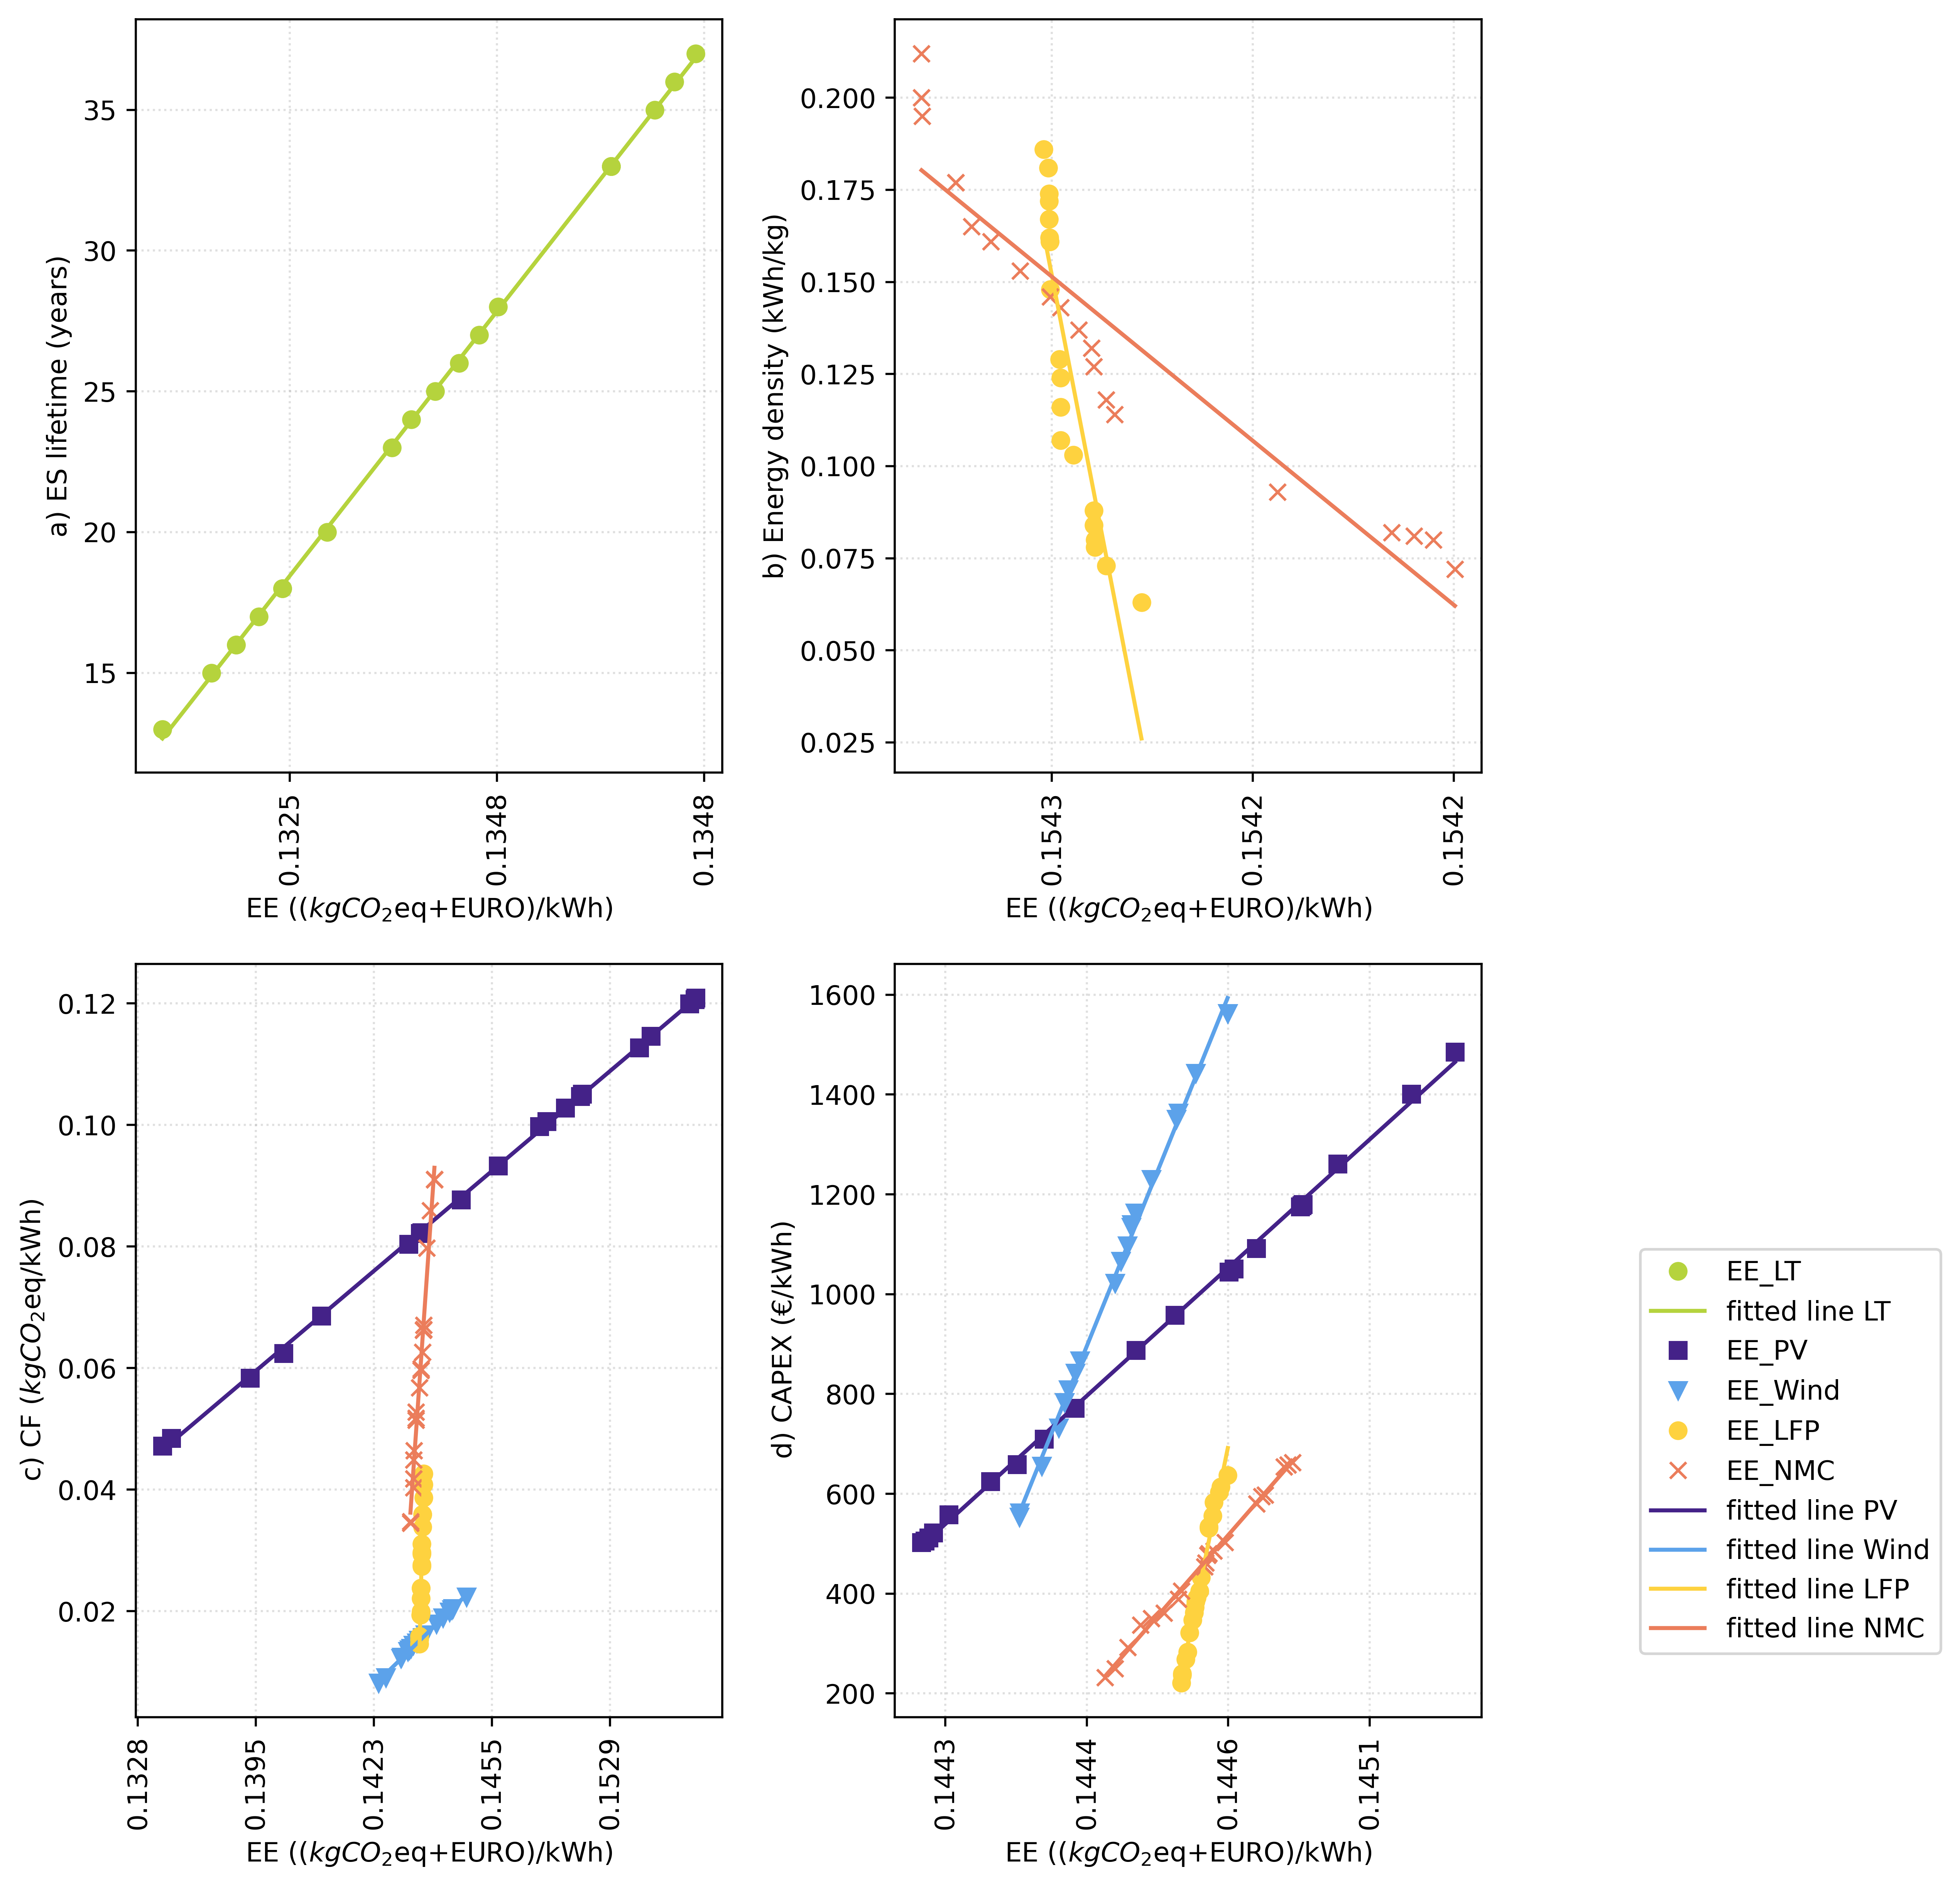

In [67]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), tight_layout=TRUE)

axes[0,0].plot(x2, y2, "o", color="#B5D33D", label='EE_LT')
axes[0,0].plot(x2, res2.intercept + res2.slope*x2, color="#B5D33D", label='fitted line LT')
axes[0,0].grid(linestyle='dotted',alpha=0.4)
axes[0,0].set_ylabel('a) ES lifetime (years)')
axes[0,0].set_xlabel('EE (($kgCO_2$eq+EURO)/kWh)')
#axes[0,0].legend()
axes[0,0].set_xticklabels(['{:,.4f}'.format(a) for a in x2], rotation=90)

axes[0,1].plot(x5, y5, "o", color='#FED23F')
axes[0,1].plot(x6, y6, "x" , color='#EB7D5B')
axes[0,1].plot(x5, res5.intercept + res5.slope*x5, color='#FED23F')
axes[0,1].plot(x6, res6.intercept + res6.slope*x6, color='#EB7D5B')
axes[0,1].grid(linestyle='dotted',alpha=0.4)
axes[0,1].set_ylabel('b) Energy density (kWh/kg)')
axes[0,1].set_xlabel('EE (($kgCO_2$eq+EURO)/kWh)')
axes[0,1].set_xticklabels(['{:,.4f}'.format(a) for a in x5], rotation=90)

axes[1,0].plot(x7, y7, "s", color='#442288')
axes[1,0].plot(x8, y8, "v", color='#5CA2EA')
axes[1,0].plot(x9, y9, "o", color='#FED23F')
axes[1,0].plot(x10, y10, "x", color='#EB7D5B')               
axes[1,0].plot(x7, res7.intercept + res7.slope*x7, color='#442288')
axes[1,0].plot(x8, res8.intercept + res8.slope*x8, color='#5CA2EA')
axes[1,0].plot(x9, res9.intercept + res9.slope*x9, color='#FED23F')
axes[1,0].plot(x10, res10.intercept + res10.slope*x10, color='#EB7D5B')
axes[1,0].grid(linestyle='dotted',alpha=0.4)
axes[1,0].set_ylabel('c) CF ($kgCO_2$eq/kWh)')
axes[1,0].set_xlabel('EE (($kgCO_2$eq+EURO)/kWh)')
axes[1,0].set_xticklabels(['{:,.4f}'.format(a) for a in x7], rotation=90)

axes[1,1].plot(x11, y11, "s", color='#442288', label='EE_PV')
axes[1,1].plot(x12, y12, "v", color='#5CA2EA', label='EE_Wind')
axes[1,1].plot(x13, y13, "o", color='#FED23F', label='EE_LFP')
axes[1,1].plot(x14, y14, "x", color='#EB7D5B', label='EE_NMC')               
axes[1,1].plot(x11, res11.intercept + res11.slope*x11, color='#442288', label='fitted line PV')
axes[1,1].plot(x12, res12.intercept + res12.slope*x12, color='#5CA2EA', label='fitted line Wind')
axes[1,1].plot(x13, res13.intercept + res13.slope*x13, color='#FED23F', label='fitted line LFP')
axes[1,1].plot(x14, res14.intercept + res14.slope*x14, color='#EB7D5B', label='fitted line NMC')
axes[1,1].grid(linestyle='dotted',alpha=0.4)
axes[1,1].set_ylabel('d) CAPEX ($€$/kWh)')
axes[1,1].set_xlabel('EE (($kgCO_2$eq+EURO)/kWh)')
#axes[1,1].legend(bbox_to_anchor=(1.7, 0.0), loc='lower right', ncol= 1, fontsize=10)
axes[1,1].set_xticklabels(['{:,.4f}'.format(a) for a in x11], rotation=90)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

# Finally, the legend (that maybe you'll customize differently)
fig.legend(lines, labels, bbox_to_anchor=(1.28, 0.125), loc='lower right', ncol=1)
plt.rcParams.update({'font.size': 14})
plt.show()

In [68]:
change_lfp_1 = sen2['se5'].min()/sen2['se5'].mean()
print(change_lfp_1*100-100)

change_lfp_2 = sen2['se5'].max()/sen2['se5'].mean()
print(change_lfp_2*100-100)

change_nmc_1 = sen2['se6'].min()/sen2['se6'].mean()
print(change_nmc_1*100-100)

change_nmc_2 = sen2['se6'].max()/sen2['se6'].mean()
print(change_nmc_2*100-100)

change_nmc_1 = sen2['se6'].min()/sen2['se6'].mean()
print(change_nmc_1*100-100)

change_years_1 = sen2['se2'].min()/sen2['se2'].mean()
print(change_years_1*100-100)

change_years_2 = sen2['se2'].max()/sen2['se2'].mean()
print(change_years_2*100-100)

#print(sen2['Density LFP'])

-0.08105593148432888
0.23447735708192852
-0.6124231377472853
1.1085901010794146
-0.6124231377472853
-16.629669374269028
16.949312272747747
